In [4]:
import pandas as pd
import pickle
from pathlib import Path
from collections import namedtuple
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
from scipy import stats
%matplotlib inline

# Display more rows and get rid of the margins
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth',500)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Display mulitiple values from each cell
# https://stackoverflow.com/a/42476224
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [12]:
ModPermRes = namedtuple("ModPermRes",['pn','fn','name', 'clf', 'ho_score','cfn'])
VarPermRes = namedtuple("VarPermRes", ["pn", "metric", "int_r2", "agh_r2", "aghs_r2", "aghss_r2", "aghsss_r2"])

def get_pn(perm_pkz):
    return int(perm_pkz.parts[-1].split('_')[0].split('-')[1])

def get_crt(perm_pkz):
    pn = int(perm_pkz.parts[-1].split('_')[0].split('-')[1])
    task = perm_pkz.parts[-1].split('_')[2]
    contrast = perm_pkz.parts[-1].split('_')[3]
    run = perm_pkz.parts[-1].split('_')[4]
    return pn, task, contrast, run

def get_varex(df):
    df['agh_varex'] = (df.agh_r2 - df.int_r2) * 100
    df['mfg_varex'] = (df.aghs_r2 - df.agh_r2) * 100
    df['model_varex'] = (df.aghss_r2 - df.aghs_r2) * 100
    df['site_varex'] = (df.aghsss_r2 - df.aghss_r2) * 100
    return df

def adjr2_to_r2(y, n, p):
    """Converts adjusted R2 to unadjusted R2
    Based on formula here: https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
    
    Parameters
    ----------
    y: float
        adjusted R2 you'd like to convert
    n: int
        number of samples
    p: int
        number of parameters
    
    Returns
    -------
    res: float
        adjusted R2
    """
    res = (((n - 1) * y) + (p * (-1 * y)) + p)/ (n - 1)
    return res

def get_unadj_r2(df, n):
    df['int_r2'] = adjr2_to_r2(df.int_r2, n, 1)
    df['agh_r2'] = adjr2_to_r2(df.agh_r2, n, 4)
    df['aghs_r2'] = adjr2_to_r2(df.aghs_r2, n, 5)
    df['aghss_r2'] = adjr2_to_r2(df.aghss_r2, n, 6)
    df['aghsss_r2'] = adjr2_to_r2(df.aghsss_r2, n, 7)
    return df

def make_bar_list(factors, to_plot, to_plot_sig, group_offset=1.5, left_start=0, cols = 2,
                  sig_palette=sns.color_palette('muted'), palette=sns.color_palette('pastel'),
                  error=None, group_var=None,sort_var=None, sig_exclude=[],
                  stack=True):
    """Make input for bar chart that will give two columns of stacked bars"""
    fplist = []
    left = np.zeros(len(to_plot)) + left_start
    height = 0.8
    if not stack:
        height /= len(factors)
    for i,vf in enumerate(factors):
        fdict = {'bottom': [], 'width': [], 'left':left.copy(), 'color':[], 'label': [], 'tick_label': [], 'height':height}
        if error is not None:
            fdict['xerr'] = []
        if group_var is not None:
            fdict[group_var] = []
        yoffset=0

        if group_var is not None:
            for x,df in to_plot.groupby(group_var):
                if not stack:
                    fdict['bottom'].extend(list(np.arange(len(df)) + yoffset + height * i))
                else:
                    fdict['bottom'].extend(list(np.arange(len(df)) + yoffset))
                fdict['width'].extend(list(df[vf].values))
                fdict['tick_label'].extend(list(df.label.values))
                yoffset += len(df)+group_offset
                if group_var is not None:
                    fdict[group_var].extend(list(df[group_var].values))
                labels = np.array([vf]*len(df))
                colors = np.array([palette[i]]*len(df))
                
                if vf not in sig_exclude:
                    sig_mask = df[vf].values >= to_plot_sig[vf]
                    labels[sig_mask] = 'Sig. ' + vf
                    colors[sig_mask] = sig_palette[i]
                fdict['color'].extend(list(colors))
                fdict['label'].extend(list(labels))
                if error is not None:
                    fdict['xerr'].extend(list(df[error[i]].values))
        else:
            df = to_plot
            if sort_var is not None:
                df = df.sort_values(sort_var)
            if not stack:
                fdict['bottom'].extend(list(np.arange(len(df)) + yoffset + height * i))
            else:
                fdict['bottom'].extend(list(np.arange(len(df)) + yoffset))
            fdict['width'].extend(list(df[vf].values))
            fdict['tick_label'].extend(list(df.label.values))
            if error is not None:
                fdict['xerr'].extend(list(df[error[i]].values))
            yoffset += len(df)+group_offset
            if group_var is not None:
                fdict[group_var].extend(list(df[group_var].values))
            labels = np.array([vf]*len(df))
            colors = np.array([palette[i]]*len(df))
            if vf not in sig_exclude:
                sig_mask = df[vf].values >= to_plot_sig[vf]
                labels[sig_mask] = 'Sig. ' + vf
                colors[sig_mask] = sig_palette[i]
            fdict['color'].extend(list(colors))
            fdict['label'].extend(list(labels))
        

        fdict['width'] = np.array(fdict['width'])
        fdict['width'][fdict['width']<0] = 0

        fdf = pd.DataFrame(fdict)
        fdf['col'] = cols - 1 - pd.cut(fdf['bottom'], cols, labels = np.arange(cols)).astype(int)
        if group_var is not None:
            fdf = fdf.merge(pd.DataFrame(fdf.groupby(group_var).col.max()).reset_index(), on=group_var, suffixes=['_bad','']).drop('col_bad', axis=1)
        fplist.append(fdf)
        yoffset += group_offset
        if stack:
            left += np.array(fdict['width'])
    return fplist

In [8]:
data_dir = Path('data')
swarm_out_dir = Path('swarm_out')

# Load Data

In [21]:
# Either load consolidated permutation results or load individual permuatation pkzs and consolidate them
con_mod_res_path = data_dir/'con_mod_separate_1000.pkz'
var_res_path = data_dir/'var_res_separate_1000.pkz'
cb_var_res_path = data_dir/'cb_var_res_separate_1000.pkz'

try:
    con_mod_res = pd.read_pickle(con_mod_res_path)
    var_res = pd.read_pickle(var_res_path).reset_index(drop=True)
    cb_var_res = pd.read_pickle(cb_var_res_path).reset_index(drop=True)
except FileNotFoundError:
    con_pks = sorted(list(swarm_out_dir.glob('*_con.pkz')))
    con_mod_res = []
    var_res = []
    cb_var_res = []
    for pk in con_pks:
        with open(pk, 'rb') as h:
            pkr = pickle.load(h)
        con_mod_res.append(pd.DataFrame(pkr[0]))
        var_res.append(pd.DataFrame(pkr[1]))
        cb_var_res.append(pd.DataFrame(pkr[2]))
    con_mod_res = pd.concat(con_mod_res)
    var_res = pd.concat(var_res)
    cb_var_res = pd.concat(cb_var_res)
    con_mod_res.to_pickle(con_mod_res_path)
    var_res.to_pickle(var_res_path)
    cb_var_res.to_pickle(cb_var_res_path)
    
# I saved out adjusted R2, charles reccomends I use unadjusted R2 instead
var_res = get_unadj_r2(var_res, 2159)
cb_var_res = get_unadj_r2(cb_var_res, 2159)
var_res = get_varex(var_res)
cb_var_res = get_varex(cb_var_res)


In [11]:
# Check number of permutations
con_mod_res.pn.nunique()

1001

# Generate plot of variance explained, figure 3

In [29]:
# Create the paper context
sns.set_context('paper',font_scale = 0.8 )
sns.set_style('white')

In [23]:
# Get significance threshold for percent variance explained
sig_df = var_res.groupby('pn')['agh_varex','mfg_varex','model_varex','site_varex'].max().quantile([0.999]).iloc[0, :]
cb_sig_df =cb_var_res.groupby('pn')['agh_varex','mfg_varex','model_varex','site_varex'].max().quantile([0.999]).iloc[0, :]
sig_df

agh_varex      3.447892
mfg_varex      1.156033
model_varex    1.082364
site_varex     1.643200
Name: 0.999, dtype: float64

In [24]:
to_plot = var_res.merge(cb_var_res.loc[:,['pn','metric','agh_varex','mfg_varex','model_varex','site_varex']], on = ['pn','metric'], suffixes=('','_cb')).query('pn==0')
to_plot['label'] = to_plot.metric.str.split('_').str[1:].str.join(' ').str.title().str.replace(' To ', '-')


cm_ind = (to_plot.mfg_varex >= sig_df.mfg_varex) | (to_plot.model_varex >= sig_df.model_varex) | (to_plot.site_varex >= sig_df.site_varex)
# Look at the number of metrics that have significant
# variance accounted for by mfg, model, or site
cm_ind.sum()

# Look at the list of significant metrics
to_plot.loc[cm_ind, ['metric', 'label']]

to_plot = to_plot.loc[cm_ind,:].rename(columns={'mfg_varex': 'Manufacturer','model_varex': 'Model','site_varex': 'Site','agh_varex': 'Age, Gender, & Handedness'})
to_plot_sig = sig_df.rename(index={'mfg_varex': 'Manufacturer','model_varex': 'Model','site_varex': 'Site','agh_varex': 'Age, Gender, & Handedness'})
to_plot_sig_cb = cb_sig_df.rename(index={'mfg_varex': 'mfg_varex_cb','model_varex': 'model_varex_cb','site_varex': 'site_varex_cb','agh_varex': 'agh_varex_cb'})

174

,metric,label
0,rsfm_mean_motion,Mean Motion
1,rsfm_max_motion,Max Motion
2,rsfm_mean_trans,Mean Trans
3,rsfm_max_trans,Max Trans
4,rsfm_mean_rot,Mean Rot
5,rsfm_max_rot,Max Rot
6,rsfm_auditory_to_auditory,Auditory-Auditory
7,rsfm_auditory_to_cingulooperc,Auditory-Cingulooperc
14,rsfm_auditory_to_smhand,Auditory-Smhand
15,rsfm_auditory_to_smmouth,Auditory-Smmouth


In [25]:
# Define factors
varex_factors = ['Manufacturer','Model','Site','Age, Gender, & Handedness']
cb_factors = ['mfg_varex_cb','model_varex_cb','site_varex_cb','agh_varex_cb']

# Define the names of hte motion metrics
motion_metrics = ['Mean Motion',
                  'Max Trans',
                  'Mean Rot',
                  'Max Motion',
                  'Max Rot',
                  'Mean Trans']

In [26]:
# Create sort key
to_plot['sort_key'] = np.nan
sort_vars = ['Manufacturer','Model','Site']
remain_max = 0
for i, sv in enumerate(sort_vars[::-1]):
    remain_max += to_plot.loc[:,sort_vars[::-1][i:]].values.max()+1
    skind = ((to_plot[sv] > to_plot_sig[sv]))
    to_plot.loc[skind, 'sort_key'] = to_plot.loc[skind,sv] + remain_max

    
# Make bar lists for uncorrected and combat corrected data
uncorlist = make_bar_list(varex_factors, to_plot, to_plot_sig, cols = 3, sort_var='sort_key')
cblist = make_bar_list(cb_factors, to_plot, to_plot_sig_cb, left_start = 23, cols = 3, sort_var='sort_key')

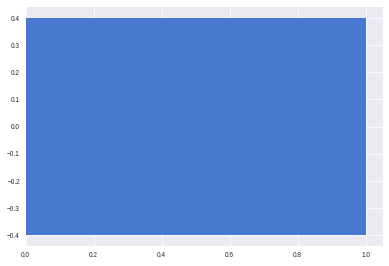

In [27]:
# This is hacky, but in order to get the legend I want,
# I'm creating it here, and then using the object in the actual figure

fig,ax = plt.subplots(1)
sig_palette=sns.color_palette('muted')[0:len(varex_factors)]
palette=sns.color_palette('pastel')[0:len(varex_factors)]
bottom = np.zeros(len(varex_factors)*2)
width = np.ones(len(varex_factors)*2)
leg_labels = []
colors = []
for i,vf in enumerate(varex_factors):
    if 'ag' not in vf.lower():
        colors.append(sig_palette[i])
        leg_labels.append('Sig. '+vf)
    leg_labels.append(vf)
    colors.append(palette[i])
leg_labels[-1] = 'Sex, Handedness, &  Age'
# Change name of site to scanner
leg_labels[5] = 'Scanner'
leg_labels[4] = 'Sig. Scanner'
leg_bar = ax.barh(bottom, width, color=colors, label=leg_labels)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
  if sys.path[0] == '':


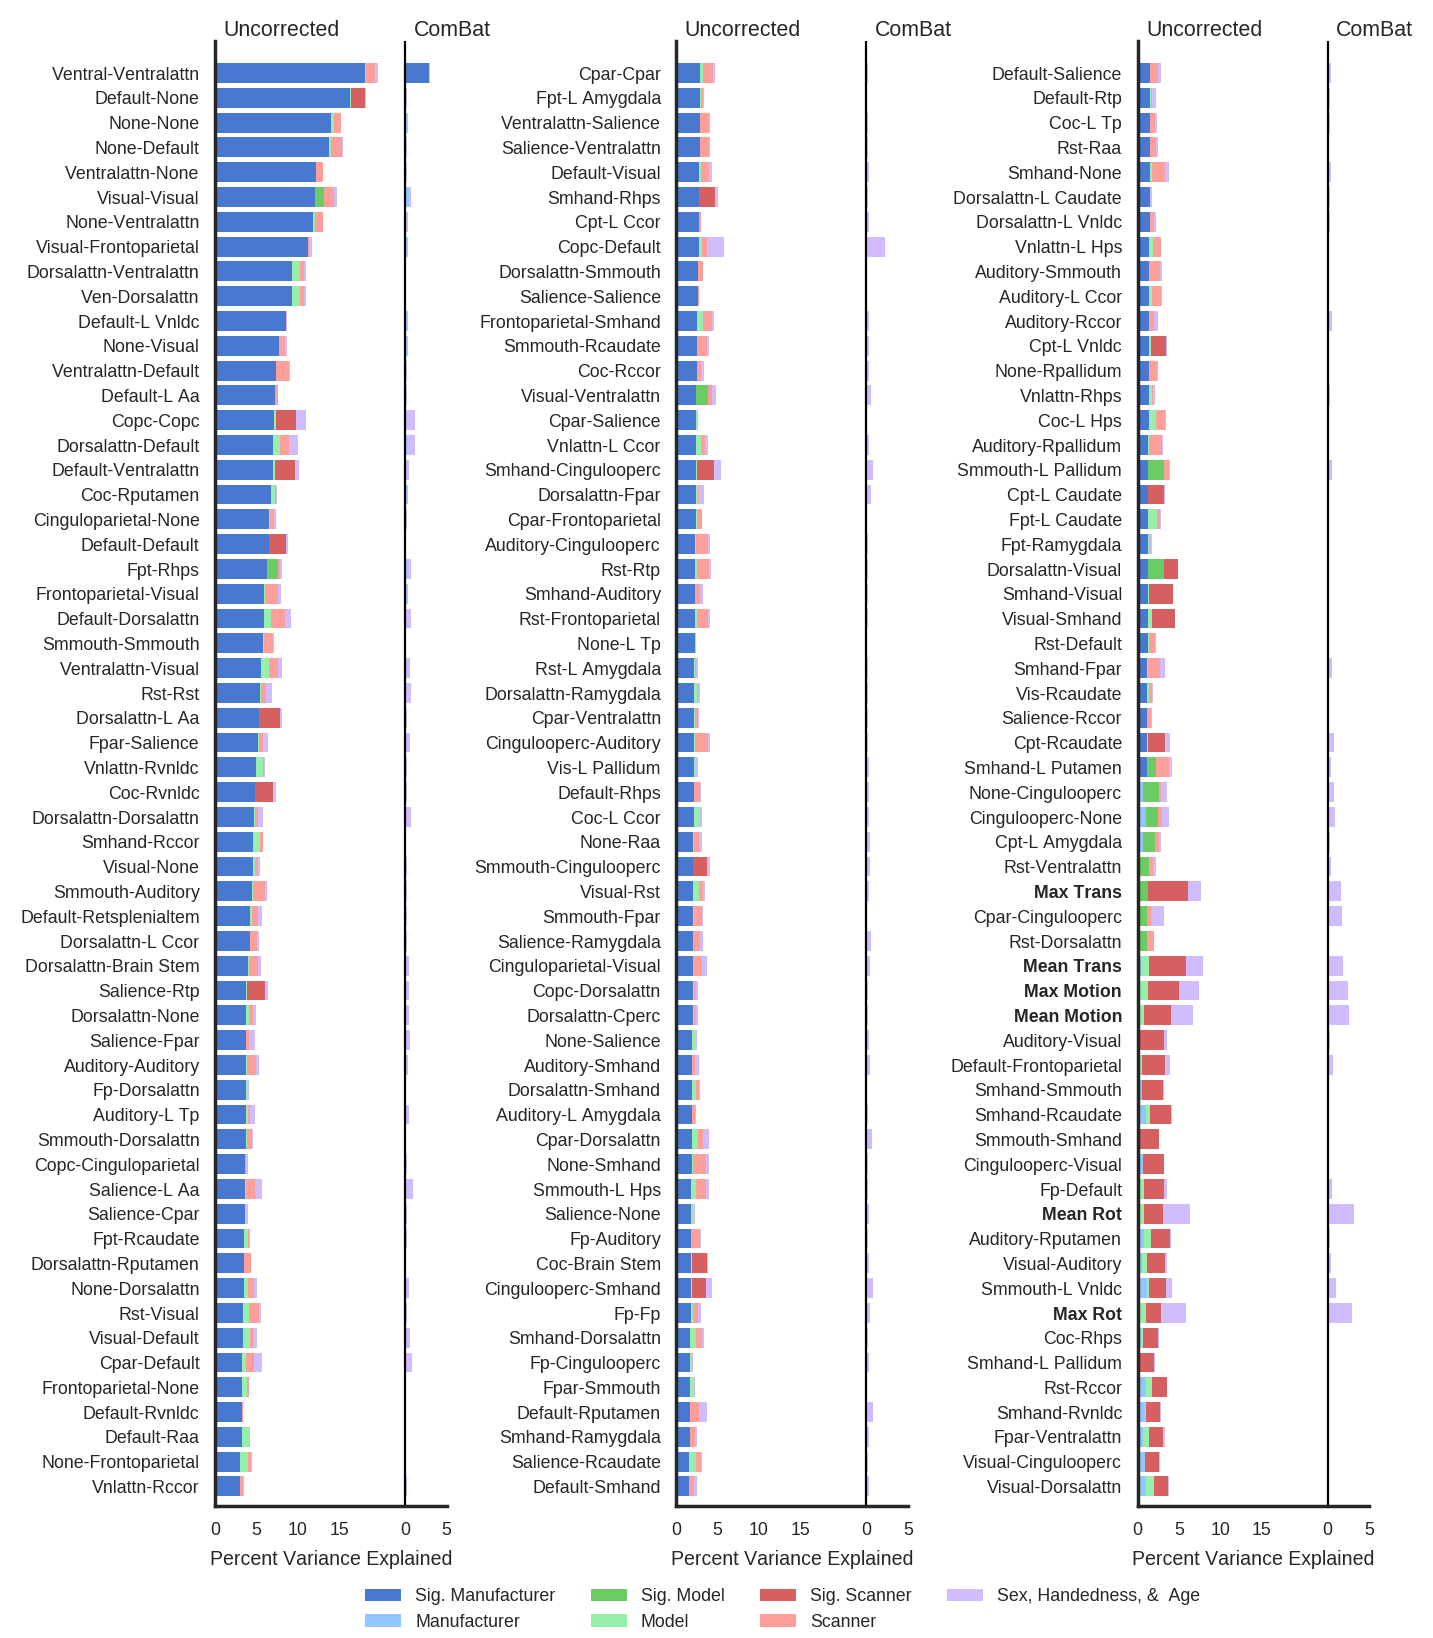

In [30]:

fig, axes = plt.subplots(1, 3, figsize=(7,8), dpi=200)

for col in np.arange(len(axes)):
    ax = axes[col]
    for uc, cb in zip(uncorlist, cblist):
        barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left', 'tick_label', 'width']].to_dict('list')
        cb_barh_dict = cb.loc[cb.col == col, ['bottom', 'color', 'left', 'tick_label', 'width']].to_dict('list')

        #names = uc.loc[uc.col == col, ['metric']]
        _plot = ax.barh(**barh_dict)
        _plot = ax.barh(**cb_barh_dict)
    #name_df = uc.loc[uc.col == col, ['bottom', 'metric']].groupby('metric').max().reset_index()
    #for ii, row in name_df.iterrows():
    #    _text = ax.text(11, row.bottom + 1, row.metric, va='bottom', ha='center')
    yb,yt = ax.get_ylim()
    _vl = ax.vlines(23, yb,yt, lw=0.8)
    _lim = ax.set_ylim((yb,yt))
    t = ax.set_xticks([0,5,10,15,23, 28])
    _tl = ax.set_xticklabels([0,5,10,15,0, 5])
    _ylims = ax.set_ylim((yb+2.5, yt-2))
    _t = ax.text(1, np.max(barh_dict['bottom']) + 1.5, 'Uncorrected')
    _t = ax.text(24, np.max(barh_dict['bottom']) + 1.5, 'ComBat')
    _t = ax.set_xlabel('Percent Variance Explained')
    for tl in ax.get_yticklabels():
        txt = tl.get_text()
        if txt in motion_metrics:
            _tl = tl.set_weight('bold')
fig.tight_layout()
fig.legend(leg_bar, leg_labels, loc=(0.25,0), ncol=4 )    
fig.subplots_adjust(bottom = 0.07)

sns.despine(fig)

### Bonus figures: looking at how combat changes the variance explained

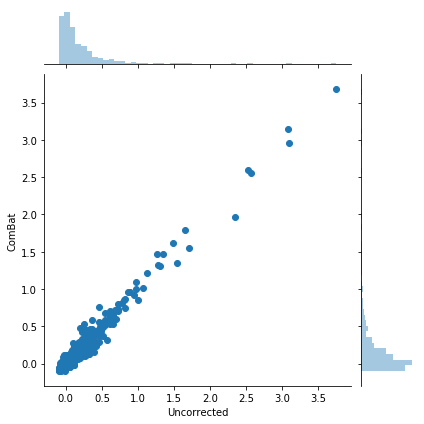

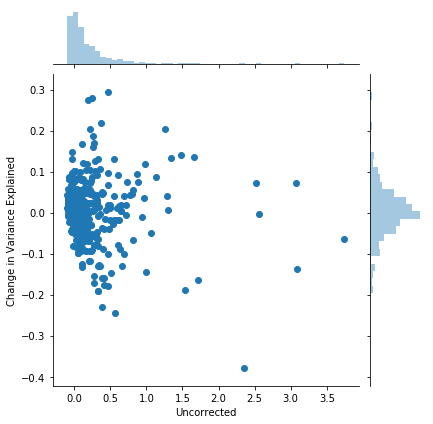

In [64]:
to_plot=var_res.query('pn==0').rename(columns={'agh_varex':'Uncorrected', 'agh_varex_cb': 'ComBat'})
to_plot['Change in Variance Explained'] = to_plot['ComBat'] - to_plot['Uncorrected']
sns.jointplot( to_plot.loc[:,'Uncorrected'], to_plot.loc[:,'ComBat'], stat_func=None )
sns.jointplot(  to_plot.loc[:,'Uncorrected'], to_plot.loc[:,'Change in Variance Explained'], stat_func=None )

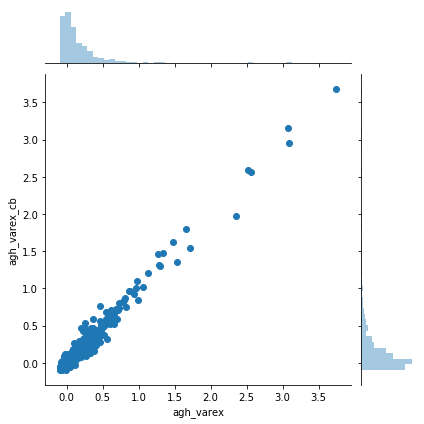

In [55]:
sns.jointplot( var_res.query('pn==0').agh_varex,var_res.query('pn==0').agh_varex_cb, stat_func=None )

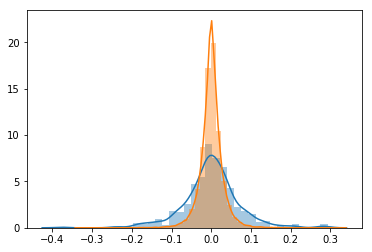

In [47]:
sns.distplot(var_res.query('pn==0').agh_varex_cb - var_res.query('pn==0').agh_varex )

# Model fit results

In [33]:
con_mod_res.groupby(['name', 'pn'])[['ho_score']].mean().query('pn == 0')
con_mod_res.groupby(['name', 'pn'])[['ho_score']].mean().reset_index().groupby('name')[['ho_score']].min()#.quantile([0,0.1, 0.9,1 ])

,,ho_score
name,pn,
ab_combat,0,0.141821
ab_normal,0,0.275179
age_rsd,0,0.350675
cbagersd,0,0.148953
combat,0,0.149817
normal,0,0.352940


,ho_score
name,
ab_combat,0.066667
ab_normal,0.062744
age_rsd,0.068479
cbagersd,0.071371
combat,0.067769
normal,0.067731


In [ ]:
mod_names = ['normal', 'age_rsd', 'ab_normal']
cb_mod_names = ['combat', 'cbagersd', 'ab_combat']

In [7]:
test_vals = con_mod_res.groupby(['name', 'pn'])[['ho_score']].mean().reset_index().query('pn == 0').drop('pn',axis=1).set_index('name').values
null_max_vals = con_mod_res.groupby(['name','pn'])[['ho_score']].mean().reset_index().query('name in @mod_names').groupby( ['pn'])[['ho_score']].max().values.flatten()
null_min_vals = con_mod_res.groupby(['name','pn'])[['ho_score']].mean().reset_index().query('name in @mod_names').groupby( ['pn'])[['ho_score']].min().values.flatten()

In [8]:
con_mod_res.groupby(['name','pn'])[['ho_score']].mean().reset_index().query('name in @mod_names').min()#.groupby( ['pn'])[['ho_score']].min()

name        ab_normal
pn                  0
ho_score    0.0627436
dtype: object

In [9]:
null_min_vals.min()
null_max_vals.max()

0.062743589743589748

0.35294001339162628

In [10]:
test_vals

array([[ 0.14182051],
       [ 0.27517949],
       [ 0.35067517],
       [ 0.14895325],
       [ 0.14981669],
       [ 0.35294001]])

In [11]:
2 * (1 - (test_vals >= null_max_vals).mean(1))
2 * (1 -(test_vals <= null_min_vals).mean(1))

array([ 0.001998,  0.001998,  0.001998,  0.001998,  0.001998,  0.      ])

array([ 1.998002,  1.998002,  2.      ,  1.998002,  1.998002,  2.      ])

In [195]:
con_mod_to_plot = con_mod_res.groupby(['pn', 'name'])[['ho_score']].agg(['mean' ,'std']).query('pn == 0').reset_index()
con_mod_to_plot.columns = [' '.join(col).strip() for col in con_mod_to_plot.columns.values]
con_mod_to_plot = con_mod_to_plot.drop('pn', axis=1)
con_mod_to_plot['ho_score std'] *= 100
con_mod_to_plot['ho_score mean'] *= 100
con_mod_to_plot['label'] = 'Rest'
#con_mod_to_plot.loc[con_mod_to_plot.contrast.str.contains('condition'), 'label'] = con_mod_to_plot.contrast.str.split('-').str[1:-1].str.join('-').str.title() + '* ' + con_mod_to_plot.run.str.split('.').str[0].str[-1]
#con_mod_to_plot.loc[~con_mod_to_plot.contrast.str.contains('condition'), 'label'] = con_mod_to_plot.contrast.str.replace('contrast', '').str.replace('fixation', 'Fix').str.replace('reward', 'Rewd').str.replace('small', 'Sm').str.replace('large', 'Lg').str.replace('neutral', 'Neut').str.replace('positive', 'Pos').str.replace('negative', 'Neg').str.replace('anticipation', 'Ant').str.replace('-any', '').str.replace('correct', 'cor').str.replace('-of', '').str.split('-').str[1:].str.join(' ').str.title().str.replace('Versus', 'v').str.replace('Feeback', 'FB').str.replace('Feedback', 'FB') + ' ' + con_mod_to_plot.run.str.split('.').str[0].str[-1]


In [196]:
con_mod_to_plot

,name,ho_score mean,ho_score std,label
0,ab_combat,14.182051,2.271341,Rest
1,ab_normal,27.517949,3.287100,Rest
2,age_rsd,35.067517,2.116831,Rest
3,cbagersd,14.895325,1.484675,Rest
4,combat,14.981669,1.526427,Rest
5,normal,35.294001,2.041468,Rest


In [197]:
wide_df = (con_mod_to_plot.query('name == @mod_names[0]')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":mod_names[0], "ho_score std":mod_names[0]+"_std"})
                          .drop("name", axis=1))
for name in mod_names[1:]:
    tmp = (con_mod_to_plot.query('name == @name')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":name, "ho_score std":name+"_std"})
                          .drop("name", axis=1))
    wide_df = wide_df.merge(tmp, how='left', on=['label'])
    
cb_wide_df = (con_mod_to_plot.query('name == @cb_mod_names[0]')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":cb_mod_names[0], "ho_score std":cb_mod_names[0]+"_std"})
                          .drop("name", axis=1))
for name in cb_mod_names[1:]:
    tmp = (con_mod_to_plot.query('name == @name')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":name, "ho_score std":name+"_std"})
                          .drop("name", axis=1))
    cb_wide_df = cb_wide_df.merge(tmp, how='left', on=['label'])

In [221]:
sig_thresh = {'normal': 100*con_mod_res.groupby(['name','pn'])[['ho_score']].mean().reset_index().query('name in @mod_names').groupby( ['pn'])[['ho_score']].max().quantile([0.999]).values[0][0]}
sig_thresh['combat'] = 100*con_mod_res.groupby(['name', 'pn'])[['ho_score']].mean().reset_index().query('name in @cb_mod_names').groupby( ['pn'])[['ho_score']].max().quantile([0.999]).values[0][0]
sig_thresh['age_rsd'] = sig_thresh['normal']
sig_thresh['cbagersd'] = sig_thresh['combat']
sig_thresh['ab_normal'] = sig_thresh['normal']
sig_thresh['ab_combat'] = sig_thresh['combat']

In [228]:
con_mod_res.head()

,pn,fn,name,clf,ho_score,cfn
0,0,0,normal,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.320099,"[[3, 4, 8, 0, 0, 1, 3, 4, 5, 0, 2, 1, 0], [4, 10, 6, 0, 1, 0, 1, 3, 4, 0, 2, 0, 0], [4, 3, 8, 0, 0, 3, 0, 4, 3, 0, 5, 0, 1], [0, 2, 1, 11, 0, 3, 0, 1, 0, 6, 3, 3, 1], [0, 0, 0, 0, 23, 0, 1, 0, 1, 0, 0, 3, 3], [0, 2, 2, 0, 0, 8, 2, 3, 4, 5, 5, 0, 0], [3, 0, 4, 0, 0, 1, 6, 4, 3, 3, 1, 3, 3], [4, 3, 2, 0, 1, 2, 5, 6, 3, 0, 2, 3, 0], [2, 5, 4, 0, 1, 2, 0, 1, 5, 1, 5, 5, 0], [0, 0, 1, 4, 2, 0, 2, 3, 3, 12, 0, 3, 1], [4, 0, 3, 0, 1, 3, 5, 3, 3, 4, 4, 0, 1], [1, 0, 1, 5, 0, 2, 3, 0, 2, 4, 1, 11, 1]..."
1,0,0,age_rsd,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.320099,"[[4, 4, 7, 0, 0, 1, 3, 4, 5, 0, 2, 1, 0], [3, 11, 5, 0, 1, 0, 1, 4, 4, 0, 2, 0, 0], [3, 4, 9, 0, 0, 2, 0, 4, 2, 1, 4, 0, 2], [0, 2, 1, 10, 0, 4, 0, 1, 0, 6, 3, 3, 1], [0, 0, 0, 0, 23, 0, 1, 0, 1, 0, 1, 2, 3], [0, 2, 3, 0, 0, 7, 2, 3, 5, 4, 5, 0, 0], [4, 0, 4, 0, 0, 1, 6, 4, 3, 2, 2, 2, 3], [4, 3, 2, 0, 1, 2, 5, 6, 3, 1, 2, 2, 0], [3, 5, 4, 1, 1, 2, 0, 1, 4, 1, 5, 4, 0], [0, 0, 1, 4, 2, 0, 2, 3, 3, 11, 1, 3, 1], [4, 0, 2, 0, 1, 3, 6, 3, 4, 4, 4, 0, 0], [1, 0, 2, 5, 0, 2, 3, 0, 2, 2, 1, 12, 1]..."
2,0,0,cbagersd,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.136476,"[[5, 4, 4, 4, 0, 2, 3, 5, 0, 2, 1, 1, 0], [3, 5, 3, 0, 2, 1, 0, 5, 4, 4, 1, 2, 1], [4, 2, 3, 3, 2, 3, 1, 3, 2, 3, 2, 1, 2], [1, 1, 1, 10, 2, 3, 0, 1, 0, 4, 2, 5, 1], [3, 1, 1, 1, 3, 3, 3, 2, 2, 2, 2, 4, 4], [0, 4, 3, 1, 1, 5, 5, 4, 1, 3, 3, 0, 1], [3, 3, 2, 0, 1, 2, 4, 3, 2, 1, 3, 4, 3], [6, 4, 3, 2, 0, 4, 3, 2, 2, 1, 2, 1, 1], [1, 5, 3, 4, 3, 4, 3, 1, 3, 0, 1, 2, 1], [1, 1, 0, 3, 3, 2, 3, 4, 1, 4, 2, 5, 2], [2, 1, 4, 2, 3, 3, 3, 3, 3, 1, 3, 2, 1], [2, 2, 4, 4, 1, 4, 2, 1, 1, 4, 0, 5, 1], [0..."
3,0,0,combat,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.151365,"[[4, 5, 4, 3, 0, 2, 3, 5, 1, 2, 1, 1, 0], [4, 5, 2, 0, 2, 1, 1, 5, 4, 3, 1, 2, 1], [4, 3, 4, 3, 2, 2, 1, 4, 1, 3, 2, 1, 1], [1, 1, 1, 11, 1, 3, 1, 1, 0, 4, 2, 4, 1], [4, 2, 0, 1, 4, 3, 3, 2, 2, 1, 1, 4, 4], [1, 4, 3, 1, 1, 5, 5, 3, 2, 3, 2, 0, 1], [2, 2, 2, 0, 1, 2, 6, 2, 2, 1, 2, 6, 3], [3, 4, 3, 2, 0, 4, 4, 3, 3, 1, 2, 1, 1], [1, 6, 2, 4, 2, 4, 4, 1, 3, 0, 1, 3, 0], [3, 1, 0, 3, 3, 2, 3, 5, 1, 3, 2, 3, 2], [1, 0, 5, 1, 3, 2, 3, 4, 1, 3, 5, 2, 1], [1, 2, 4, 4, 1, 4, 2, 1, 1, 4, 1, 5, 1], [1..."
4,0,1,normal,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.389744,"[[6, 4, 8, 1, 0, 1, 1, 4, 2, 1, 2, 0, 0], [1, 13, 7, 1, 1, 1, 0, 3, 0, 0, 2, 1, 0], [6, 3, 10, 0, 0, 1, 3, 3, 2, 0, 2, 0, 0], [0, 0, 1, 12, 1, 0, 2, 1, 1, 3, 2, 7, 0], [0, 1, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 4], [2, 2, 4, 2, 0, 11, 1, 2, 1, 1, 3, 1, 0], [1, 4, 1, 3, 0, 0, 8, 3, 2, 0, 6, 2, 0], [4, 1, 4, 0, 1, 3, 3, 7, 3, 0, 3, 1, 0], [3, 3, 3, 2, 0, 2, 4, 5, 5, 0, 2, 0, 1], [0, 0, 2, 6, 0, 1, 0, 1, 0, 15, 1, 4, 0], [0, 1, 6, 0, 1, 5, 2, 7, 3, 0, 5, 0, 0], [2, 2, 1, 2, 0, 1, 2, 0, 2, 5, 1, 11, ..."


In [238]:
uncor_df = con_mod_res.query('name in @mod_names').loc[:, ['pn', 'fn', 'name', 'ho_score']]
combat_df = con_mod_res.query('name in @cb_mod_names').loc[:, ['pn', 'fn', 'name', 'ho_score']]
combat_df['name'] = combat_df.name.str.replace('combat', 'normal').str.replace('cbagersd', 'age_rsd')
uncb_df = uncor_df.merge(combat_df, how='left', on=['pn', 'fn', 'name'], suffixes=('', '_combat'))
uncb_df['dif'] = uncb_df.ho_score - uncb_df.ho_score_combat

In [249]:
stats.ttest_1samp(uncb_df.groupby(['pn','name'])[['dif']].mean().query('name == "ab_normal" & pn != 0').values.squeeze(), 0)

Ttest_1sampResult(statistic=-0.86449461707745279, pvalue=0.38752376300990587)

In [201]:
cb_sig_thresh = {'combat': 100*con_mod_res.groupby(['name', 'pn'])[['ho_score']].mean().reset_index().query('name in @cb_mod_names').groupby( ['pn'])[['ho_score']].max().quantile([0.999]).values[0][0]}
cb_sig_thresh['cbagersd'] = cb_sig_thresh['combat']
cb_sig_thresh['ab_combat'] = cb_sig_thresh['combat']


In [222]:
sig_thresh

{'ab_combat': 8.894871794872488,
 'ab_normal': 9.648717948720865,
 'age_rsd': 9.648717948720865,
 'cbagersd': 8.894871794872488,
 'combat': 8.894871794872488,
 'normal': 9.648717948720865}

In [215]:
uncorlist = make_bar_list(mod_names, wide_df, sig_thresh, cols = 1, error=[mn + '_std' for mn in mod_names], stack=False)
cblist = make_bar_list(cb_mod_names, cb_wide_df, sig_thresh, left_start = 43, cols = 1, error=[mn + '_std' for mn in cb_mod_names], stack=False)

<Container object of 6 artists>

 <Container object of 6 artists>]

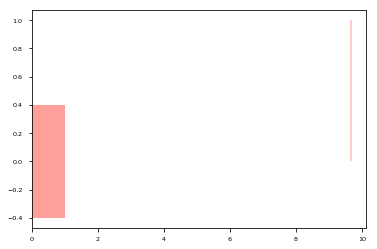

In [216]:
fig,ax = plt.subplots(1)
sig_palette=sns.color_palette('muted')[0:len(mod_names)]
palette=sns.color_palette('pastel')[0:len(mod_names)]
bottom = np.zeros(len(mod_names)*2)
width = np.ones(len(mod_names)*2)
leg_labels = []
colors = []
for i,vf in enumerate(mod_names):
    colors.append(sig_palette[i])
    leg_labels.append('Sig. '+vf)
    leg_labels.append(vf)
    colors.append(palette[i])
ax.barh(bottom, width, color=colors, label=['Sig. Raw', 'Raw','Sig. Age Regressed', 'Age Regressed' ])
ax.vlines(sig_thresh['normal'], 0,2-1, colors = 'r', lw=0.4, label='Multiple Comparison\nCorrected p<0.001')
leg_hand, leg_labels = ax.get_legend_handles_labels()
leg_hand
handles = []
handles.extend(leg_hand[1])
handles.append(leg_hand[0])

labels = ['Sig. Raw', 'Raw', 'Sig. Age Regressed', 'Age Regressed', 'Sig. Age Balanced', 'Age Balanced']
labels.append(leg_labels[0])

In [217]:
leg_reo = [0, 2, 4, 6, 1, 3, 5]
labels = list(np.array(labels)[leg_reo])
handles = list(np.array(handles)[leg_reo])

In [218]:
# Look for significant differences between uncorrected and combat
score_df = con_mod_res.groupby(['name','pn'])[['ho_score']].mean().reset_index()

In [219]:
t_res = []
for mn, cn in zip(mod_names, cb_mod_names):
    m_res =  con_mod_res.query('name == @mn').loc[:,['pn','fn','ho_score']]
    cb_res = con_mod_res.query('name == @cn').loc[:,['pn','fn','ho_score']]
    m_res = m_res.merge(cb_res, how='left', on=['pn','fn'], suffixes=('', '_cb'))
    for x,df in m_res.groupby('pn'):
        t,p = stats.ttest_ind(df.ho_score, df.ho_score_cb, equal_var=False)
        t_res.append({'mn':mn,'pn':x, 't':t, 'p':p})
    

In [207]:
t_res = pd.DataFrame(t_res)
t_res['t_abs'] = np.abs(t_res.t)
t_res.query('pn==0').t_abs.apply(lambda x:(x<=t_res.groupby( ['pn'])[['t_abs']].max().values).mean())

0       0.000999
1001    0.000999
2002    0.000999
Name: t_abs, dtype: float64

In [208]:
t_res['t_abs'] = np.abs(t_res.t)

In [209]:
t_res.query('pn==0').t_abs.apply(lambda x:(x<=t_res.groupby( ['pn'])[['t_abs']].max().values).mean())

0       0.000999
1001    0.000999
2002    0.000999
Name: t_abs, dtype: float64

In [210]:
con_mod_res.query('name == @mn').loc[:,['pn','fn','name','ho_score']]

,pn,fn,name,ho_score
300,0,0,ab_normal,0.276923
302,0,1,ab_normal,0.282051
304,0,2,ab_normal,0.225641
306,0,3,ab_normal,0.282051
308,0,4,ab_normal,0.276923
310,0,5,ab_normal,0.301282
312,0,6,ab_normal,0.246154
314,0,7,ab_normal,0.269231
316,0,8,ab_normal,0.266667
318,0,9,ab_normal,0.320513


In [211]:
sns.set_context('paper', font_scale=0.8)

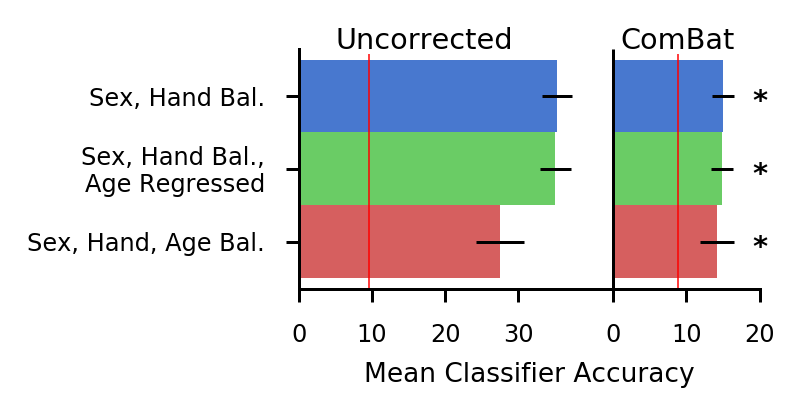

In [220]:

fig, ax = plt.subplots(1, figsize=(3,1.5), dpi=270)

col = 0
for uc, cb in zip(uncorlist, cblist):
    uc = uc.copy()
    cb = cb.copy()
    uc.bottom = 0 - uc.bottom
    cb.bottom = 0 - cb.bottom
    barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left',  'width', 'height', 'xerr']].to_dict('list')
    cb_barh_dict = cb.loc[cb.col == col, ['bottom', 'color', 'left', 'width', 'height', 'xerr']].to_dict('list')

    #names = uc.loc[uc.col == col, ['task']]
    _plot = ax.barh(**barh_dict, error_kw={'elinewidth':0.8})
    _plot = ax.barh(**cb_barh_dict, error_kw={'elinewidth':0.8})
#name_df = uc.loc[uc.col == col, ['bottom', 'task']].groupby('task').max().reset_index()
#for ii, row in name_df.iterrows():
#    _text = ax.text(11, row.bottom + 1, row.metric, va='bottom', ha='center')
yb,yt = ax.get_ylim()
#_ylims = ax.set_ylim((np.max(barh_dict['bottom'])-plot_range-1, np.max(barh_dict['bottom'])+2))
_vl = ax.vlines(43, yb,yt, lw=0.8)
_vl = ax.vlines(sig_thresh['normal'], yb,yt-0.02, colors = 'r', lw=0.4)
#_vl = ax.vlines(low_sig_thresh['normal'], yb,yt-0.02, colors = 'r', lw=0.4)

_vl = ax.vlines(43+sig_thresh['combat'], yb,yt-0.02, colors = 'r', lw=0.4)
#_vl = ax.vlines(43+low_sig_thresh['normal'], yb,yt-0.02, colors = 'r', lw=0.4)

_lim = ax.set_ylim((yb,yt))
t = ax.set_xticks([0,10,20,30,43, 53, 63])
_tl = ax.set_xticklabels([0,10,20,30,0, 10, 20])
#_ylims = ax.set_ylim((yb, yt))
_t = ax.text(5, yt, 'Uncorrected')
_t = ax.text(44, yt, 'ComBat')
#_t = ax.set_title(name_df.task.values[0])
_t = ax.set_xlabel('Mean Classifier Accuracy')
_yt = ax.set_yticks(0-pd.concat(uncorlist).bottom)
_ytl = ax.set_yticklabels(['Sex, Hand Bal.', 'Sex, Hand Bal.,\nAge Regressed', 'Sex, Hand, Age Bal.'])

for yval in (0-pd.concat(uncorlist).bottom):
    _s = ax.text(63, yval-0.021, '*', va='center', ha='center', fontweight='bold')

fig.tight_layout()
#_leg = fig.legend(handles, labels, ncol=2 , loc=(0.6,0.5))    
#fig.subplots_adjust(bottom = 0.12)

sns.despine(fig)

Classifier Performance Before and After ComBat for Resting State Functional Connectivity

Bars show mean classifier performance across 3 fold cross-validation for raw and age regressed data and split half cross-vaidation for age balanced data from 25 gender and handedness balanced draws for resting state functional connetivity metrics. Error bars indicate standard deviation across draws and cross-validation folds. We ran 1079 permutations balanced across gender, handedness and age in 3 month bins to determine chance classifier performance. The red line indicates the multiple comparison corrected p < 0.001 threshold. Bars with performance greater than this cut off are indicated with more saturated colors. Classifier performance on data with no corrections for age are shown in blue. Green bars show classifier performance in which the effect of age learned on the training split within each cross validation fold was regressed out of each ROI. Red bars show classifier performance using a restricted dataset in which we were able to draw samples balanced for gender, handedness and age in three month bins from each site. The uncorrected columns show results without running ComBat to correct for site effects. The ComBat columns show classifier performance after correcting for site effects with ComBat based on parameters learned from the training split within each cross validation.

# Look at confusion matrix

In [26]:
def off_diag(a):
    return ~np.eye(a.shape[0],dtype=bool)

def make_signed_ps(upper, lower):
    signed_ps = upper.copy()
    signed_ps[upper > lower] = lower[upper > lower] * -1
    return signed_ps

def get_cfn_sig(cfns, perm_cfns):
    # add true data to permuted data and generate null distributions
    diag_null_upper = np.array([list(np.diag(cm)) for cm in perm_cfns.mean(1)]+[list(np.diag(cfns.mean(0)))]).max(1)
    diag_null_lower = np.array([list(np.diag(cm)) for cm in perm_cfns.mean(1)]+[list(np.diag(cfns.mean(0)))]).min(1)

    od_null_upper = np.array([list(cm[off_diag(cm)]) for cm in perm_cfns.mean(1)]+[list(cfns.mean(0)[off_diag(cfns.mean(0))])]).max(1)
    od_null_lower = np.array([list(cm[off_diag(cm)]) for cm in perm_cfns.mean(1)]+[list(cfns.mean(0)[off_diag(cfns.mean(0))])]).min(1)
    
    # Calculate p values, correcting for multiple comparisons
    diag_upper_ps = np.array([val < diag_null_upper for val in  np.diag(cfns.mean(0))]).mean(1)
    diag_lower_ps = np.array([val > diag_null_lower for val in  np.diag(cfns.mean(0))]).mean(1)

    off_diag_upper_ps = np.array([val < od_null_upper for val in  cfns.mean(0)[off_diag(cfns.mean(0))]]).mean(1)
    off_diag_lower_ps = np.array([val > od_null_lower for val in  cfns.mean(0)[off_diag(cfns.mean(0))]]).mean(1)
    
    # Combine upper and lower thresholds 
    diag_signed_ps = make_signed_ps(diag_upper_ps, diag_lower_ps)
    off_diag_signed_ps = make_signed_ps(off_diag_upper_ps, off_diag_lower_ps)

    # load diagonal and off diagnal values back into shape
    cfn_signed_ps = np.ones(cfns.mean(0).shape)
    cfn_signed_ps[np.diag_indices_from(cfn_signed_ps)] = diag_signed_ps
    cfn_signed_ps[off_diag(cfn_signed_ps)] = off_diag_signed_ps
    
    return cfn_signed_ps

def get_cfn_sig(cfns, perm_cfns):
    null_upper_tail = perm_cfns.mean(1).max(-1).max(-1)
    null_lower_tail = perm_cfns.mean(1).min(-1).min(-1)

    upper_ps = np.array([val <= null_upper_tail for val in  cfns.mean(0).flatten()]).mean(1)
    lower_ps = np.array([val >= null_lower_tail for val in  cfns.mean(0).flatten()]).mean(1)
    
    cfn_signed_ps = make_signed_ps(upper_ps, lower_ps).reshape(cfns[0].shape)
    return cfn_signed_ps

In [27]:

con_mod_res.head()

,pn,fn,name,clf,ho_score,cfn
0,0,0,normal,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.320099,"[[3, 4, 8, 0, 0, 1, 3, 4, 5, 0, 2, 1, 0], [4, 10, 6, 0, 1, 0, 1, 3, 4, 0, 2, 0, 0], [4, 3, 8, 0, 0, 3, 0, 4, 3, 0, 5, 0, 1], [0, 2, 1, 11, 0, 3, 0, 1, 0, 6, 3, 3, 1], [0, 0, 0, 0, 23, 0, 1, 0, 1, 0, 0, 3, 3], [0, 2, 2, 0, 0, 8, 2, 3, 4, 5, 5, 0, 0], [3, 0, 4, 0, 0, 1, 6, 4, 3, 3, 1, 3, 3], [4, 3, 2, 0, 1, 2, 5, 6, 3, 0, 2, 3, 0], [2, 5, 4, 0, 1, 2, 0, 1, 5, 1, 5, 5, 0], [0, 0, 1, 4, 2, 0, 2, 3, 3, 12, 0, 3, 1], [4, 0, 3, 0, 1, 3, 5, 3, 3, 4, 4, 0, 1], [1, 0, 1, 5, 0, 2, 3, 0, 2, 4, 1, 11, 1]..."
1,0,0,age_rsd,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.320099,"[[4, 4, 7, 0, 0, 1, 3, 4, 5, 0, 2, 1, 0], [3, 11, 5, 0, 1, 0, 1, 4, 4, 0, 2, 0, 0], [3, 4, 9, 0, 0, 2, 0, 4, 2, 1, 4, 0, 2], [0, 2, 1, 10, 0, 4, 0, 1, 0, 6, 3, 3, 1], [0, 0, 0, 0, 23, 0, 1, 0, 1, 0, 1, 2, 3], [0, 2, 3, 0, 0, 7, 2, 3, 5, 4, 5, 0, 0], [4, 0, 4, 0, 0, 1, 6, 4, 3, 2, 2, 2, 3], [4, 3, 2, 0, 1, 2, 5, 6, 3, 1, 2, 2, 0], [3, 5, 4, 1, 1, 2, 0, 1, 4, 1, 5, 4, 0], [0, 0, 1, 4, 2, 0, 2, 3, 3, 11, 1, 3, 1], [4, 0, 2, 0, 1, 3, 6, 3, 4, 4, 4, 0, 0], [1, 0, 2, 5, 0, 2, 3, 0, 2, 2, 1, 12, 1]..."
2,0,0,cbagersd,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.136476,"[[5, 4, 4, 4, 0, 2, 3, 5, 0, 2, 1, 1, 0], [3, 5, 3, 0, 2, 1, 0, 5, 4, 4, 1, 2, 1], [4, 2, 3, 3, 2, 3, 1, 3, 2, 3, 2, 1, 2], [1, 1, 1, 10, 2, 3, 0, 1, 0, 4, 2, 5, 1], [3, 1, 1, 1, 3, 3, 3, 2, 2, 2, 2, 4, 4], [0, 4, 3, 1, 1, 5, 5, 4, 1, 3, 3, 0, 1], [3, 3, 2, 0, 1, 2, 4, 3, 2, 1, 3, 4, 3], [6, 4, 3, 2, 0, 4, 3, 2, 2, 1, 2, 1, 1], [1, 5, 3, 4, 3, 4, 3, 1, 3, 0, 1, 2, 1], [1, 1, 0, 3, 3, 2, 3, 4, 1, 4, 2, 5, 2], [2, 1, 4, 2, 3, 3, 3, 3, 3, 1, 3, 2, 1], [2, 2, 4, 4, 1, 4, 2, 1, 1, 4, 0, 5, 1], [0..."
3,0,0,combat,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.151365,"[[4, 5, 4, 3, 0, 2, 3, 5, 1, 2, 1, 1, 0], [4, 5, 2, 0, 2, 1, 1, 5, 4, 3, 1, 2, 1], [4, 3, 4, 3, 2, 2, 1, 4, 1, 3, 2, 1, 1], [1, 1, 1, 11, 1, 3, 1, 1, 0, 4, 2, 4, 1], [4, 2, 0, 1, 4, 3, 3, 2, 2, 1, 1, 4, 4], [1, 4, 3, 1, 1, 5, 5, 3, 2, 3, 2, 0, 1], [2, 2, 2, 0, 1, 2, 6, 2, 2, 1, 2, 6, 3], [3, 4, 3, 2, 0, 4, 4, 3, 3, 1, 2, 1, 1], [1, 6, 2, 4, 2, 4, 4, 1, 3, 0, 1, 3, 0], [3, 1, 0, 3, 3, 2, 3, 5, 1, 3, 2, 3, 2], [1, 0, 5, 1, 3, 2, 3, 4, 1, 3, 5, 2, 1], [1, 2, 4, 4, 1, 4, 2, 1, 1, 4, 1, 5, 1], [1..."
4,0,1,normal,"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=10000, multi_class='multinomial',\n n_jobs=1, penalty='l2', random_state=None, solver='saga',\n tol=0.0001, verbose=0, warm_start=False)",0.389744,"[[6, 4, 8, 1, 0, 1, 1, 4, 2, 1, 2, 0, 0], [1, 13, 7, 1, 1, 1, 0, 3, 0, 0, 2, 1, 0], [6, 3, 10, 0, 0, 1, 3, 3, 2, 0, 2, 0, 0], [0, 0, 1, 12, 1, 0, 2, 1, 1, 3, 2, 7, 0], [0, 1, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 4], [2, 2, 4, 2, 0, 11, 1, 2, 1, 1, 3, 1, 0], [1, 4, 1, 3, 0, 0, 8, 3, 2, 0, 6, 2, 0], [4, 1, 4, 0, 1, 3, 3, 7, 3, 0, 3, 1, 0], [3, 3, 3, 2, 0, 2, 4, 5, 5, 0, 2, 0, 1], [0, 0, 2, 6, 0, 1, 0, 1, 0, 15, 1, 4, 0], [0, 1, 6, 0, 1, 5, 2, 7, 3, 0, 5, 0, 0], [2, 2, 1, 2, 0, 1, 2, 0, 2, 5, 1, 11, ..."


In [28]:
def get_cfns(df, name):
    cfns = df.query('pn == 0 & name == @name').cfn.values
    cfns = np.array([c for c in cfns])
    perm_cfns = []
    for pn in df.pn.unique():
        tmp = df.query('pn == @pn & name == @name').cfn.values
        perm_cfns.append(np.array([c for c in tmp]))

    perm_cfns = np.array(perm_cfns)
    return cfns, perm_cfns

In [29]:
cfns, perm_cfns = get_cfns(con_mod_res, 'normal')
ab_cfns, ab_perm_cfns = get_cfns(con_mod_res, 'ab_normal')
cb_cfns, cb_perm_cfns = get_cfns(con_mod_res, 'combat')


In [30]:
cfn_signed_ps = get_cfn_sig(cfns, perm_cfns)
ab_cfn_signed_ps = get_cfn_sig(ab_cfns, ab_perm_cfns)
cb_cfn_signed_ps = get_cfn_sig(cb_cfns, cb_perm_cfns)

In [727]:
cb_cfn_signed_ps = get_cfn_sig(cb_cfns, perm_cfns)
cb_model_cfns, cb_mfg_cfns, cb_model_cfn_signed_ps_norm, cb_mfg_cfn_signed_ps_norm = get_collapsed_perms(cb_cfns, perm_cfns)

In [41]:
model_cfns, mfg_cfns, model_cfn_signed_ps_norm, mfg_cfn_signed_ps_norm = get_collapsed_perms(cfns, perm_cfns)
ab_model_cfns, ab_mfg_cfns, ab_model_cfn_signed_ps_norm, ab_mfg_cfn_signed_ps_norm = get_collapsed_perms(ab_cfns, ab_perm_cfns)
cb_model_cfns, cb_mfg_cfns, cb_model_cfn_signed_ps_norm, cb_mfg_cfn_signed_ps_norm = get_collapsed_perms(cb_cfns, cb_perm_cfns)

In [ ]:
print("foo")

In [40]:
import itertools
def get_collapsed_perms(cfns, perm_cfns):
    model_cfns = np.array([collapse_group(cfn, model_lut, model_order, normalize=False) for cfn in cfns])
    #model_perm_cfns = np.array([[collapse_group(pcfn, model_lut, model_order, normalize=False) for pcfn in pc] for pc in perm_cfns])
    mfg_cfns = np.array([collapse_group(cfn, mfg_lut, mfg_order, normalize=False) for cfn in cfns])
    #mfg_perm_cfns = np.array([[collapse_group(pcfn, mfg_lut, mfg_order, normalize=False) for pcfn in pc] for pc in perm_cfns])
    
    
    model_cfns_norm = np.array([collapse_group(cfn, model_lut, model_order, normalize=True) for cfn in cfns])
    model_perm_cfns_norm = np.array([[collapse_group(pcfn, model_lut, model_order, normalize=True) for pcfn in pc] for pc in perm_cfns])
    mfg_cfns_norm = np.array([collapse_group(cfn, mfg_lut, mfg_order, normalize=True) for cfn in cfns])
    mfg_perm_cfns_norm = np.array([[collapse_group(pcfn, mfg_lut, mfg_order, normalize=True) for pcfn in pc] for pc in perm_cfns])
    
    model_cfn_signed_ps_norm = get_cfn_sig(model_cfns_norm, model_perm_cfns_norm)
    mfg_cfn_signed_ps_norm = get_cfn_sig(mfg_cfns_norm, mfg_perm_cfns_norm)
    
    return model_cfns, mfg_cfns, model_cfn_signed_ps_norm, mfg_cfn_signed_ps_norm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          signed_ps=None,
                          sig_thresh = 0.025):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.1f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        weight = 'normal'
        if signed_ps is not None:
            if np.abs(signed_ps[i, j]) < sig_thresh:
                weight = 'bold'
        if normalize == False:
            s = format(cm[i,j], fmt)
        else:
            s = format(cm[i,j], fmt)
        plt.text(j, i, s,
                 horizontalalignment="center",va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontweight=weight, size="x-small")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          numbers=False,
                          symbols=False,
                          cmap=plt.cm.Blues,
                          signed_ps=None,
                          sig_thresh = 0.025, ax=None, fig=None, colorbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    if ax is None:
        fig,ax = plt.subplots(1)
    if normalize:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    if colorbar:
        fig.colorbar(im)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, size="x-small")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes,  size="x-small")

    fmt = '.2f' if normalize else '.1f'
    thresh = 1 / 2.
    if numbers:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            weight = 'normal'
            if signed_ps is not None:
                if np.abs(signed_ps[i, j]) < sig_thresh:
                    weight = 'bold'
            if normalize == False:
                s = format(cm[i,j], fmt)
            else:
                s = format(cm[i,j], fmt)
            ax.text(j, i, s,
                     horizontalalignment="center",va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontweight=weight, size="xx-small")

    elif symbols:
        if signed_ps is not None:
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                if np.abs(signed_ps[i, j]) < sig_thresh:
                    if np.sign(1/signed_ps[i, j]) > 0:
                        s = '+'
                    elif np.sign(1/signed_ps[i, j]) < 0:
                        s = '-'
                    ax.text(j, i, s,
                             horizontalalignment="center",va="center",
                             color="white" if cm[i, j] > thresh else "black",
                             fontweight="bold")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return fig,ax, im
    
def collapse_group(cfn, group_lut, group_order, normalize=False):
    
    cfndf = pd.DataFrame(data=cfn)
    group_vals = [group_lut[ii] for ii in cfndf.index.values]
    collapsed = (cfndf
                 .assign(group=group_vals)
                 .groupby('group')
                 .sum()
                 .T
                 .assign(group=group_vals)
                 .groupby('group')
                 .sum()
                 .T
                 .loc[group_order, group_order]).values
    if normalize:
        collapsed = collapsed.astype('float') / collapsed.sum(axis=1)[:, np.newaxis]
    return collapsed

model_lut = {k:v['scanner_type_pd'] for k,v in  raw_df.groupby('cat_num')[['scanner_type_pd']].first().to_dict('index').items()}
mfg_lut = {k:v['scanner_manufacturer_pd'] for k,v in  raw_df.groupby('cat_num')[['scanner_manufacturer_pd']].first().to_dict('index').items()}

model_order = ['Prisma', 'Prisma_fit', 'DISCOVERY MR750','Achieva dStream', 'Ingenia']
model_order = ['DISCOVERY MR750','Achieva dStream', 'Ingenia', 'Prisma', 'Prisma_fit', ]

mfg_order = ['GE MEDICAL SYSTEMS', 'Philips Medical Systems', 'SIEMENS', ]

In [34]:
raw_df = pd.read_pickle('swarm_dir/big_con.pkz')
with open('swarm_dir/yfit_con.pkz', 'rb') as h:
    ymapper = pickle.load(h)

In [35]:
raw_df['cat_num'] = ymapper.transform(raw_df)


In [36]:
cat_df = raw_df.groupby('cat_num')[['scanner_manufacturer_pd',
                  'scanner_type_pd','deviceserialnumber']].first()
cat_df['mfg'] = cat_df.scanner_manufacturer_pd
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('GE'), 'mfg'] = 'GE'
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('Philips'), 'mfg'] = 'PH'
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('SIEMENS'), 'mfg'] = 'SM'

cat_df['mdl'] = cat_df.scanner_type_pd
cat_df.loc[cat_df.scanner_type_pd == 'Prisma', 'mdl'] = 'Prsm'
cat_df.loc[cat_df.scanner_type_pd == 'Prisma_fit', 'mdl'] = 'Pr-f'
cat_df.loc[cat_df.scanner_type_pd == 'DISCOVERY MR750', 'mdl'] = 'Dsc7'
cat_df.loc[cat_df.scanner_type_pd == 'Ingenia', 'mdl'] = 'Ingn'
cat_df.loc[cat_df.scanner_type_pd == 'Achieva dStream', 'mdl'] = 'Achv'

cat_df['num'] = cat_df.groupby(['scanner_manufacturer_pd', 'scanner_type_pd']).transform(lambda x:np.arange(len(x))).mdl.values

In [37]:
cat_df['mfg'] = cat_df.scanner_manufacturer_pd
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('GE'), 'mfg'] = 'GE'
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('Philips'), 'mfg'] = 'PH'
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('SIEMENS'), 'mfg'] = 'SM'


In [38]:
cat_df['mdl'] = cat_df.scanner_type_pd
cat_df.loc[cat_df.scanner_type_pd == 'Prisma', 'mdl'] = 'Prsm'
cat_df.loc[cat_df.scanner_type_pd == 'Prisma_fit', 'mdl'] = 'Pr-f'
cat_df.loc[cat_df.scanner_type_pd == 'DISCOVERY MR750', 'mdl'] = 'Dsc7'
cat_df.loc[cat_df.scanner_type_pd == 'Ingenia', 'mdl'] = 'Ingn'
cat_df.loc[cat_df.scanner_type_pd == 'Achieva dStream', 'mdl'] = 'Achv'

In [39]:
cat_df['num'] = cat_df.groupby(['scanner_manufacturer_pd', 'scanner_type_pd']).transform(lambda x:np.arange(len(x))).mdl.values

In [ ]:
fig.colorbar()

In [42]:
cat_df

,scanner_manufacturer_pd,scanner_type_pd,deviceserialnumber,mfg,mdl,num
cat_num,,,,,,
0,SIEMENS,Prisma,HASH11ad4ed5,SM,Prsm,0
1,SIEMENS,Prisma_fit,HASH1314a204,SM,Pr-f,0
2,SIEMENS,Prisma,HASH3935c89e,SM,Prsm,1
3,GE MEDICAL SYSTEMS,DISCOVERY MR750,HASH4b0b8b05,GE,Dsc7,0
4,Philips Medical Systems,Ingenia,HASH5ac2b20b,PH,Ingn,0
5,SIEMENS,Prisma,HASH5b0cf1bb,SM,Prsm,2
6,SIEMENS,Prisma_fit,HASH7911780b,SM,Pr-f,1
7,SIEMENS,Prisma_fit,HASH96a0c182,SM,Pr-f,2
8,SIEMENS,Prisma_fit,HASHb640a1b8,SM,Pr-f,3


In [43]:
cat_df['hname'] = cat_df.mfg + '_' +cat_df.mdl + '_' + cat_df.num.astype('str')

In [44]:
cat_df['sort_key'] = 0
cat_df.loc[cat_df.mfg == 'GE', 'sort_key'] = 1
cat_df.loc[cat_df.mfg == 'SM',  'sort_key'] = 2

In [45]:
reo_ind = [cat_df.sort_values(['sort_key', 'scanner_manufacturer_pd',
                  'scanner_type_pd','num']).reset_index().cat_num.values][0]
classes = cat_df.sort_values(['sort_key', 'scanner_manufacturer_pd',
                  'scanner_type_pd','num']).hname.values

In [46]:
classes = cat_df.sort_values(['sort_key', 'scanner_manufacturer_pd',
                  'scanner_type_pd','num']).hname.values

In [47]:
mdl_labels = ['Discovery\nMR750', 'Achieva\ndStream', 'Ingenia', 'Prisma', 'Prisma_fit']
mfg_labels = ['GE', 'Philips', 'Siemens']

Normalized confusion matrix
[[ 0.73438202  0.07325843  0.04629213  0.03685393  0.02741573  0.00314607
   0.00539326  0.01348315  0.00269663  0.01258427  0.00539326  0.01348315
   0.02561798]
 [ 0.10966292  0.76404494  0.01438202  0.02606742  0.01348315  0.00359551
   0.00719101  0.01078652  0.00224719  0.01662921  0.01303371  0.01213483
   0.00674157]
 [ 0.02561798  0.01348315  0.4058427   0.12764045  0.14157303  0.03011236
   0.02157303  0.0458427   0.02696629  0.04494382  0.02786517  0.02157303
   0.06696629]
 [ 0.03640449  0.01752809  0.14696629  0.42561798  0.11595506  0.0305618
   0.02202247  0.04224719  0.01033708  0.03820225  0.03460674  0.03146067
   0.04808989]
 [ 0.04808989  0.0152809   0.14202247  0.1294382   0.2988764   0.02606742
   0.02696629  0.05123596  0.04449438  0.06247191  0.04        0.0552809
   0.05977528]
 [ 0.00898876  0.00404494  0.0188764   0.02292135  0.02382022  0.24988764
   0.13123596  0.07280899  0.1047191   0.05033708  0.09977528  0.11865169
   0.093932

(None,
 <matplotlib.image.AxesImage at 0x2b2bac918ac8>)

Normalized confusion matrix
[[ 0.84067416  0.08224719  0.07707865]
 [ 0.05213483  0.64464419  0.30322097]
 [ 0.02247191  0.10213483  0.87539326]]


(None,
 <matplotlib.image.AxesImage at 0x2b2bbbd379b0>)

Normalized confusion matrix
[[ 0.19955056  0.13303371  0.0894382   0.10382022  0.07955056  0.05033708
   0.05078652  0.06022472  0.05842697  0.02966292  0.03370787  0.04539326
   0.06606742]
 [ 0.14876404  0.17842697  0.07325843  0.09842697  0.06696629  0.04629213
   0.04314607  0.06696629  0.04853933  0.05303371  0.0611236   0.05123596
   0.06382022]
 [ 0.07146067  0.05977528  0.21707865  0.1141573   0.10202247  0.04719101
   0.05977528  0.07146067  0.04674157  0.03550562  0.04404494  0.04314607
   0.08764045]
 [ 0.07865169  0.07730337  0.1411236   0.1788764   0.09932584  0.04988764
   0.05123596  0.06831461  0.0305618   0.05573034  0.05393258  0.05213483
   0.06292135]
 [ 0.09977528  0.05707865  0.10966292  0.10696629  0.14966292  0.0494382
   0.0552809   0.06876404  0.0647191   0.04539326  0.05483146  0.06426966
   0.0741573 ]
 [ 0.05303371  0.04044944  0.05617978  0.05348315  0.06831461  0.13617978
   0.09213483  0.06426966  0.09303371  0.05977528  0.1141573   0.08988764
   0.07910

(None,
 <matplotlib.image.AxesImage at 0x2b2bc20169e8>)

Normalized confusion matrix
[[ 0.32988764  0.25573034  0.41438202]
 [ 0.14801498  0.40629213  0.44569288]
 [ 0.11292135  0.20140449  0.68567416]]


(None,
 <matplotlib.image.AxesImage at 0x2b2bc27c6208>)

Normalized confusion matrix
[[ 0.69037037  0.10222222  0.06074074  0.05185185  0.0237037   0.01185185
   0.01333333  0.01185185  0.00740741  0.00740741  0.00444444  0.00740741
   0.00740741]
 [ 0.24444444  0.53333333  0.01185185  0.05481481  0.01481481  0.01037037
   0.00888889  0.02962963  0.00888889  0.02074074  0.01333333  0.0162963
   0.03259259]
 [ 0.05481481  0.0237037   0.40148148  0.12148148  0.12592593  0.02222222
   0.04592593  0.05185185  0.02074074  0.03259259  0.02814815  0.02074074
   0.05037037]
 [ 0.09777778  0.02222222  0.18518519  0.29037037  0.1037037   0.04592593
   0.05333333  0.04888889  0.02074074  0.02814815  0.02518519  0.03703704
   0.04148148]
 [ 0.09925926  0.04740741  0.17925926  0.13037037  0.1762963   0.03703704
   0.03555556  0.0562963   0.04296296  0.04148148  0.05481481  0.04
   0.05925926]
 [ 0.02666667  0.00444444  0.02962963  0.03259259  0.02962963  0.16148148
   0.13037037  0.08444444  0.13481481  0.07851852  0.12444444  0.08296296
   0.08      ]
 

(None,
 <matplotlib.image.AxesImage at 0x2b2bc96e3390>)

Normalized confusion matrix
[[ 0.78518519  0.10888889  0.10592593]
 [ 0.11506173  0.57135802  0.31358025]
 [ 0.05962963  0.12833333  0.81203704]]


(None,
 <matplotlib.image.AxesImage at 0x2b2bc96e3198>)

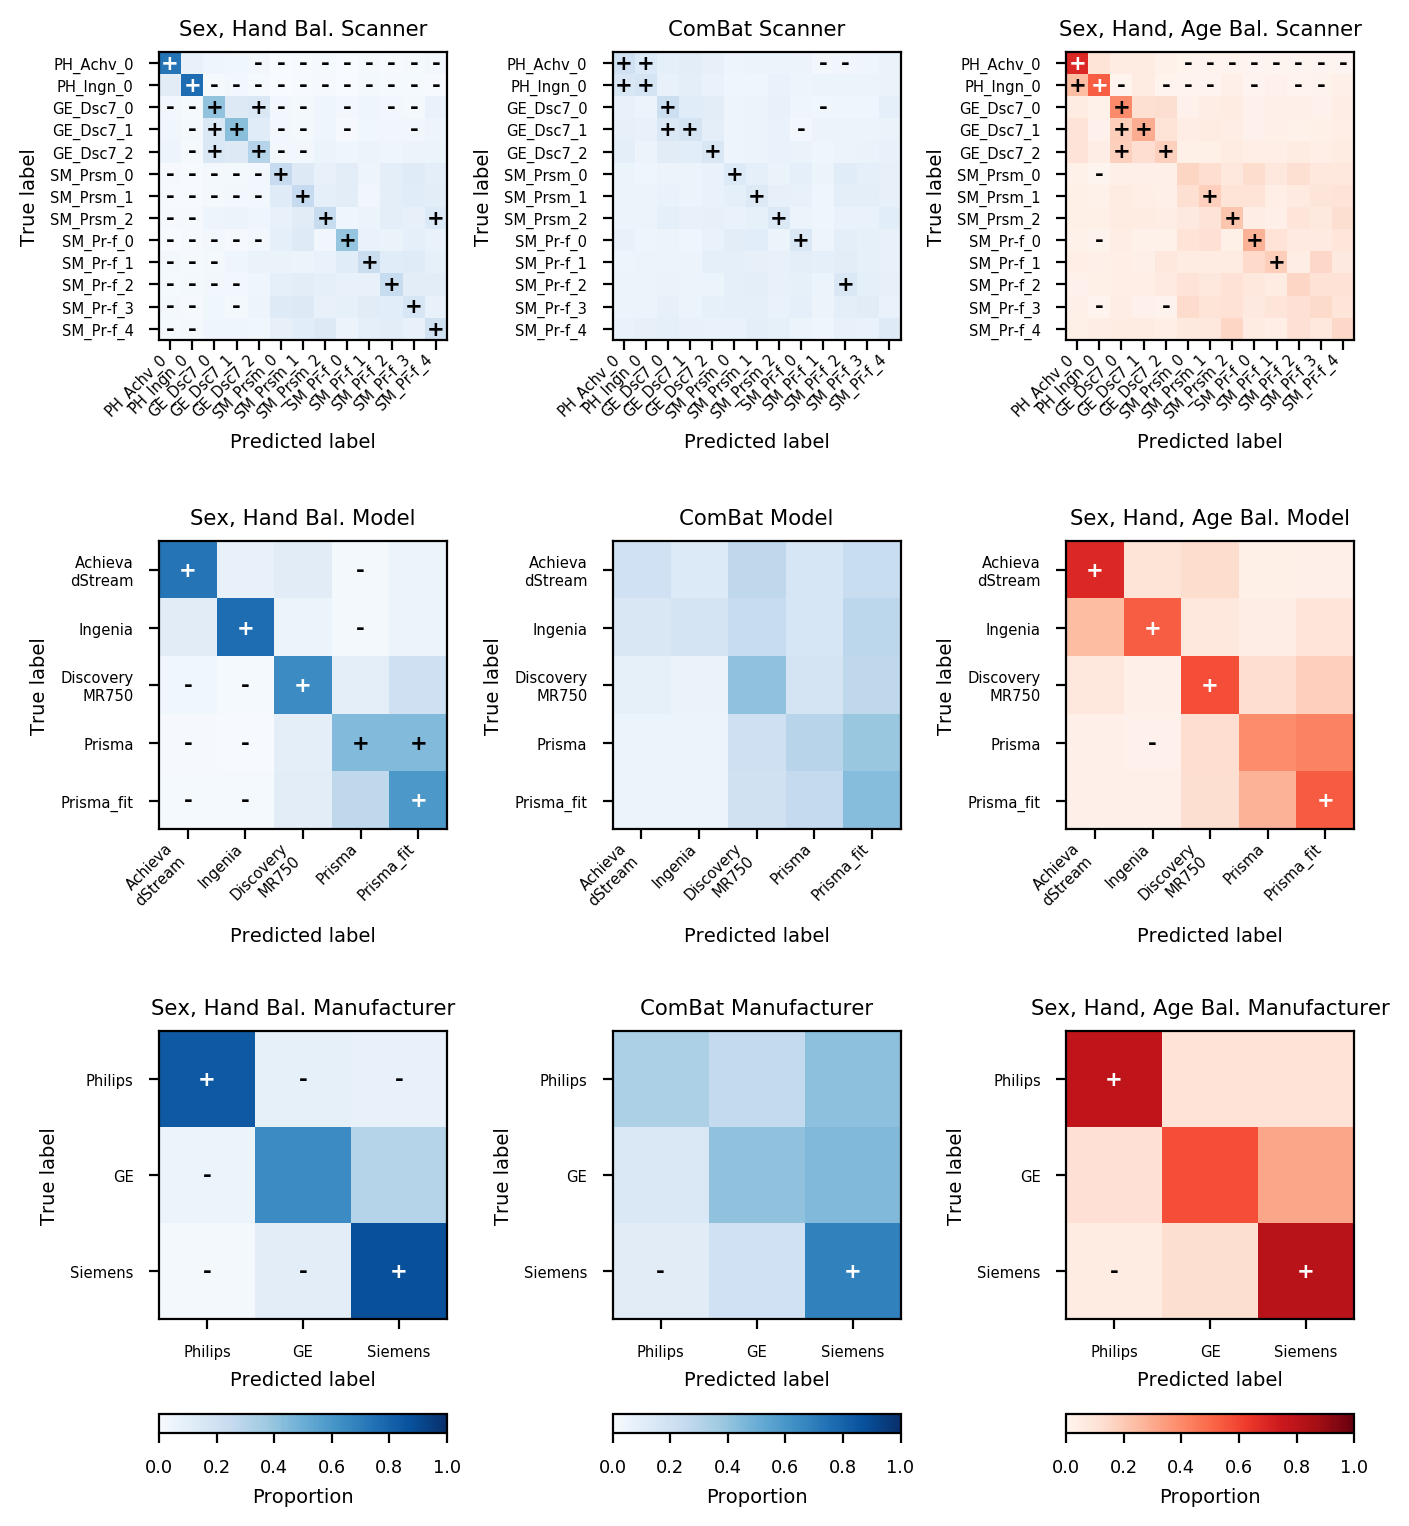

In [48]:
sns.set_context('paper', font_scale = 0.8)
#fig,axes = plt.subplots(3,1, figsize = (, 11), dpi = 100)
fig = plt.figure(figsize = (7, 8), dpi = 200)
gs = gridspec.GridSpec(4,3, height_ratios=[8,8,8,0.5])
axes = [plt.subplot(g) for g in gs]

# Raw
_fig,_ax,im0 = plot_confusion_matrix(cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="Sex, Hand Bal. Scanner",
                      signed_ps = cfn_signed_ps[reo_ind,:][:,reo_ind], colorbar=False, ax=axes[0], fig=fig, sig_thresh=0.0025, symbols=True)

labels = axes[0].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
model_cfn = model_cfns.mean(0)
model_reo = [1,2,0,3,4]
plot_confusion_matrix(model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="Sex, Hand Bal. Model",
                      signed_ps = model_cfn_signed_ps_norm[model_reo, :][:, model_reo], colorbar=False, ax=axes[3], sig_thresh=0.0025, symbols=True)
labels = axes[3].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_cfn = mfg_cfns.mean(0)
mfg_reo = [1,0,2]
plot_confusion_matrix(mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="Sex, Hand Bal. Manufacturer",
                      signed_ps = mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo],  colorbar=False, ax=axes[6], sig_thresh=0.0025, symbols=True)
#axes[0].figure.tight_layout()

# Combat
_fig,_ax,im1 = plot_confusion_matrix(cb_cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="ComBat Scanner",
                      signed_ps = cb_cfn_signed_ps[reo_ind,:][:,reo_ind], colorbar=False, ax=axes[1], fig=fig, sig_thresh=0.0025, symbols=True)

labels = axes[1].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
cb_model_cfn = cb_model_cfns.mean(0)
model_reo = [1,2,0,3,4]
plot_confusion_matrix(cb_model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="ComBat Model",
                      signed_ps = cb_model_cfn_signed_ps_norm[model_reo, :][:, model_reo], colorbar=False, ax=axes[4], sig_thresh=0.0025, symbols=True)
labels = axes[4].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_reo = [1,0,2]
cb_mfg_cfn = cb_mfg_cfns.mean(0)
plot_confusion_matrix(cb_mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="ComBat Manufacturer",
                      signed_ps = cb_mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo], colorbar=False, ax=axes[7], sig_thresh=0.0025, symbols=True)
#axes[0].figure.tight_layout()
#fig.tight_layout()



#Age balanced
_fig,_ax,im2 = plot_confusion_matrix(ab_cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="Sex, Hand, Age Bal. Scanner",
                      signed_ps = ab_cfn_signed_ps[reo_ind,:][:,reo_ind], cmap=plt.cm.Reds, colorbar=False, ax=axes[2], fig=fig, sig_thresh=0.0025, symbols=True)

labels = axes[2].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
ab_model_cfn = ab_model_cfns.mean(0)
model_reo = [1,2,0,3,4]
plot_confusion_matrix(ab_model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="Sex, Hand, Age Bal. Model",
                      signed_ps = ab_model_cfn_signed_ps_norm[model_reo, :][:, model_reo], cmap=plt.cm.Reds, colorbar=False, ax=axes[5], sig_thresh=0.0025, symbols=True)
labels = axes[5].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_reo = [1,0,2]
ab_mfg_cfn = ab_mfg_cfns.mean(0)
plot_confusion_matrix(ab_mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="Sex, Hand, Age Bal. Manufacturer",
                      signed_ps = ab_mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo], cmap=plt.cm.Reds, colorbar=False, ax=axes[8], sig_thresh=0.0025, symbols=True)
#axes[0].figure.tight_layout()
fig.tight_layout()

fig.colorbar(im0, cax = axes[9], orientation='horizontal')
axes[9].set_xlabel('Proportion')
axes[9].set_aspect(0.065)
cbbox = axes[9].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[9].set_position(cbbox)

fig.colorbar(im1, cax = axes[10], orientation='horizontal')
axes[10].set_xlabel('Proportion')
axes[10].set_aspect(0.065)
cbbox = axes[10].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[10].set_position(cbbox)

fig.colorbar(im2, cax = axes[11], orientation='horizontal')
axes[11].set_xlabel('Proportion')
axes[11].set_aspect(0.065)
cbbox = axes[11].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[11].set_position(cbbox)
#fig.tight_layout()



## Does combat reduce classifiabiilty for all sites

In [63]:
np.diagonal(cfns - cb_cfns, axis1=1, axis2=2).mean(0)

array([  3.37333333,   7.46666667,   3.57333333,   5.6       ,
        17.37333333,   2.94666667,   3.92      ,   2.65333333,
         1.52      ,   7.32      ,   2.24      ,   4.42666667,  15.86666667])

In [125]:
np.percentile(np.diagonal(perm_cfns - cb_perm_cfns, axis1=2, axis2=3).mean(1).max(1), 99.9)

1.3466666666684888

In [127]:
np.percentile(np.diagonal(perm_cfns - cb_perm_cfns, axis1=2, axis2=3).mean(1).min(1), 0.001)

-1.6095999999999999

Yep, all sites have a more significant reduction in classifiabiilty after combat than is the 99.9 percentile of maximum reductions across permutations

# Classifiability by manufacturer

In [173]:
mfg_inds = cat_df.reset_index().groupby('mfg').cat_num.unique().to_dict()
mfg_cfns = {}
perm_mfg_ts = []

for perm in ab_perm_cfns:
    for mfg, inds in mfg_inds.items():
        mfg_cfns[mfg] = np.diagonal(perm, axis1=-2, axis2=-1)[:,inds].mean(-1)/np.unique(perm.sum(-1), axis = -1).squeeze()
    mfg_cfns = pd.DataFrame(mfg_cfns)
    tmp = []
    for a,b in itertools.combinations(pd.DataFrame(mfg_cfns).T.values, 2):
        tmp.append(stats.ttest_rel(a,b)[0])
    perm_mfg_ts.append(tmp)
perm_mfg_ts = np.array(perm_mfg_ts)

In [175]:
for mfg, inds in mfg_inds.items():
    mfg_cfns[mfg] = np.diagonal(ab_cfns, axis1=-2, axis2=-1)[:,inds].mean(-1)/np.unique(ab_cfns.sum(-1), axis = -1).squeeze()
mfg_cfns = pd.DataFrame(mfg_cfns)

In [176]:
mfg_cfns.mean()
mfg_cfns.std()


GE    0.292556
PH    0.610167
SM    0.184917
dtype: float64

GE    0.074718
PH    0.100344
SM    0.038152
dtype: float64

In [177]:
null_mfg_t_thresh = np.percentile(np.abs(perm_mfg_ts).max(-1), 99.9)

In [161]:
null_mfg_t_thresh

9.9090094991389321

In [178]:
perm_mfg_ts[0]

array([-17.68941633,   9.15343617,  27.91584153])

In [163]:
mfg_inds = cat_df.reset_index().groupby('mdl').cat_num.unique().to_dict()
mfg_cfns = {}
perm_mfg_ts = []

for perm in perm_cfns:
    for mfg, inds in mfg_inds.items():
        mfg_cfns[mfg] = np.diagonal(perm, axis1=-2, axis2=-1)[:,inds].mean(-1)/np.unique(perm.sum(-1), axis = -1).squeeze()
    mfg_cfns = pd.DataFrame(mfg_cfns)
    tmp = []
    for a,b in itertools.combinations(pd.DataFrame(mfg_cfns).T.values, 2):
        tmp.append(stats.ttest_rel(a,b)[0])
    perm_mfg_ts.append(tmp)
perm_mfg_ts = np.array(perm_mfg_ts)

In [164]:
null_mfg_t_thresh = np.percentile(np.abs(perm_mfg_ts).max(-1), 99.9)

In [165]:
null_mfg_t_thresh
perm_mfg_ts[0]

8.9137163209188248

array([ 35.20889105,  -2.51082556,  47.33507531,  48.85844373,
       -44.38231143,  21.88595448,  19.48288819,  63.79273759,
        62.01860239,  -0.34063646])

Normalized confusion matrix
[[ 0.72539326  0.08404494  0.04629213  0.04224719  0.02606742  0.00539326
   0.0058427   0.01393258  0.00224719  0.00898876  0.00404494  0.01213483
   0.02337079]
 [ 0.12134831  0.74786517  0.01662921  0.02067416  0.01393258  0.00314607
   0.00494382  0.01348315  0.00314607  0.02067416  0.01303371  0.01258427
   0.00853933]
 [ 0.03191011  0.00898876  0.40494382  0.12808989  0.12314607  0.02247191
   0.02337079  0.05078652  0.02651685  0.04314607  0.03460674  0.02337079
   0.07865169]
 [ 0.02651685  0.01977528  0.14831461  0.46426966  0.0988764   0.02741573
   0.02202247  0.04359551  0.00988764  0.03640449  0.02831461  0.03191011
   0.04269663]
 [ 0.04494382  0.02022472  0.15370787  0.13797753  0.29348315  0.02966292
   0.02786517  0.04898876  0.04        0.0552809   0.03910112  0.05123596
   0.05752809]
 [ 0.00719101  0.00404494  0.01797753  0.0188764   0.02067416  0.24764045
   0.12269663  0.07955056  0.09213483  0.06561798  0.09707865  0.13977528
   0.0867

/data/nielsond/python/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in double_scalars
/data/nielsond/python/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in double_scalars


(None,
 <matplotlib.image.AxesImage at 0x2b9a695a2a20>)

Normalized confusion matrix
[[ 0.83775281  0.07865169  0.08359551]
 [ 0.05303371  0.63940075  0.30756554]
 [ 0.02241573  0.10140449  0.87617978]]


(None,
 <matplotlib.image.AxesImage at 0x2b9a69380e48>)

Normalized confusion matrix
[[ 0.2         0.15101124  0.08359551  0.08044944  0.07235955  0.05662921
   0.0458427   0.05393258  0.05483146  0.03191011  0.05123596  0.05617978
   0.06202247]
 [ 0.13438202  0.1905618   0.06651685  0.09078652  0.06337079  0.05213483
   0.04        0.06022472  0.05842697  0.05573034  0.06921348  0.05707865
   0.06157303]
 [ 0.08269663  0.0611236   0.05573034  0.15101124  0.12359551  0.05707865
   0.06292135  0.0894382   0.05977528  0.04674157  0.05348315  0.05438202
   0.10202247]
 [ 0.09617978  0.0741573   0.14337079  0.07235955  0.11325843  0.04898876
   0.05977528  0.08179775  0.04359551  0.06337079  0.05707865  0.07550562
   0.0705618 ]
 [ 0.08898876  0.08044944  0.13303371  0.11505618  0.04853933  0.05707865
   0.06247191  0.06876404  0.0647191   0.0647191   0.06831461  0.0611236
   0.08674157]
 [ 0.05213483  0.05033708  0.06202247  0.06157303  0.07775281  0.04449438
   0.10876404  0.07370787  0.10966292  0.05348315  0.11325843  0.09393258
   0.09887

(None,
 <matplotlib.image.AxesImage at 0x2b9a68549c50>)

Normalized confusion matrix
[[ 0.33797753  0.22853933  0.43348315]
 [ 0.1611985   0.31865169  0.52014981]
 [ 0.11966292  0.22640449  0.65393258]]


(None,
 <matplotlib.image.AxesImage at 0x2b9a64cd4f60>)

Normalized confusion matrix
[[ 0.59259259  0.13185185  0.08148148  0.08148148  0.01777778  0.01481481
   0.01037037  0.01777778  0.00888889  0.01333333  0.01037037  0.01185185
   0.00740741]
 [ 0.25185185  0.52148148  0.02074074  0.03703704  0.01925926  0.00888889
   0.00888889  0.01777778  0.00296296  0.02074074  0.01481481  0.02666667
   0.04888889]
 [ 0.04        0.01925926  0.42666667  0.1037037   0.09333333  0.02666667
   0.04592593  0.0562963   0.0237037   0.04296296  0.04296296  0.02518519
   0.05333333]
 [ 0.08        0.0162963   0.19407407  0.29333333  0.10666667  0.04296296
   0.06222222  0.05333333  0.03259259  0.03111111  0.02222222  0.02666667
   0.03851852]
 [ 0.10518519  0.03111111  0.16        0.13481481  0.18666667  0.03555556
   0.04444444  0.04296296  0.04592593  0.04296296  0.0562963   0.03851852
   0.07555556]
 [ 0.0237037   0.00592593  0.02666667  0.04296296  0.03555556  0.18666667
   0.12444444  0.07259259  0.08888889  0.05777778  0.11703704  0.1362963
   0.08148

(None,
 <matplotlib.image.AxesImage at 0x2b9a6727d1d0>)

Normalized confusion matrix
[[ 0.74888889  0.12888889  0.12222222]
 [ 0.09728395  0.56641975  0.3362963 ]
 [ 0.05277778  0.13574074  0.81148148]]


(None,
 <matplotlib.image.AxesImage at 0x2b9aa40a1f60>)

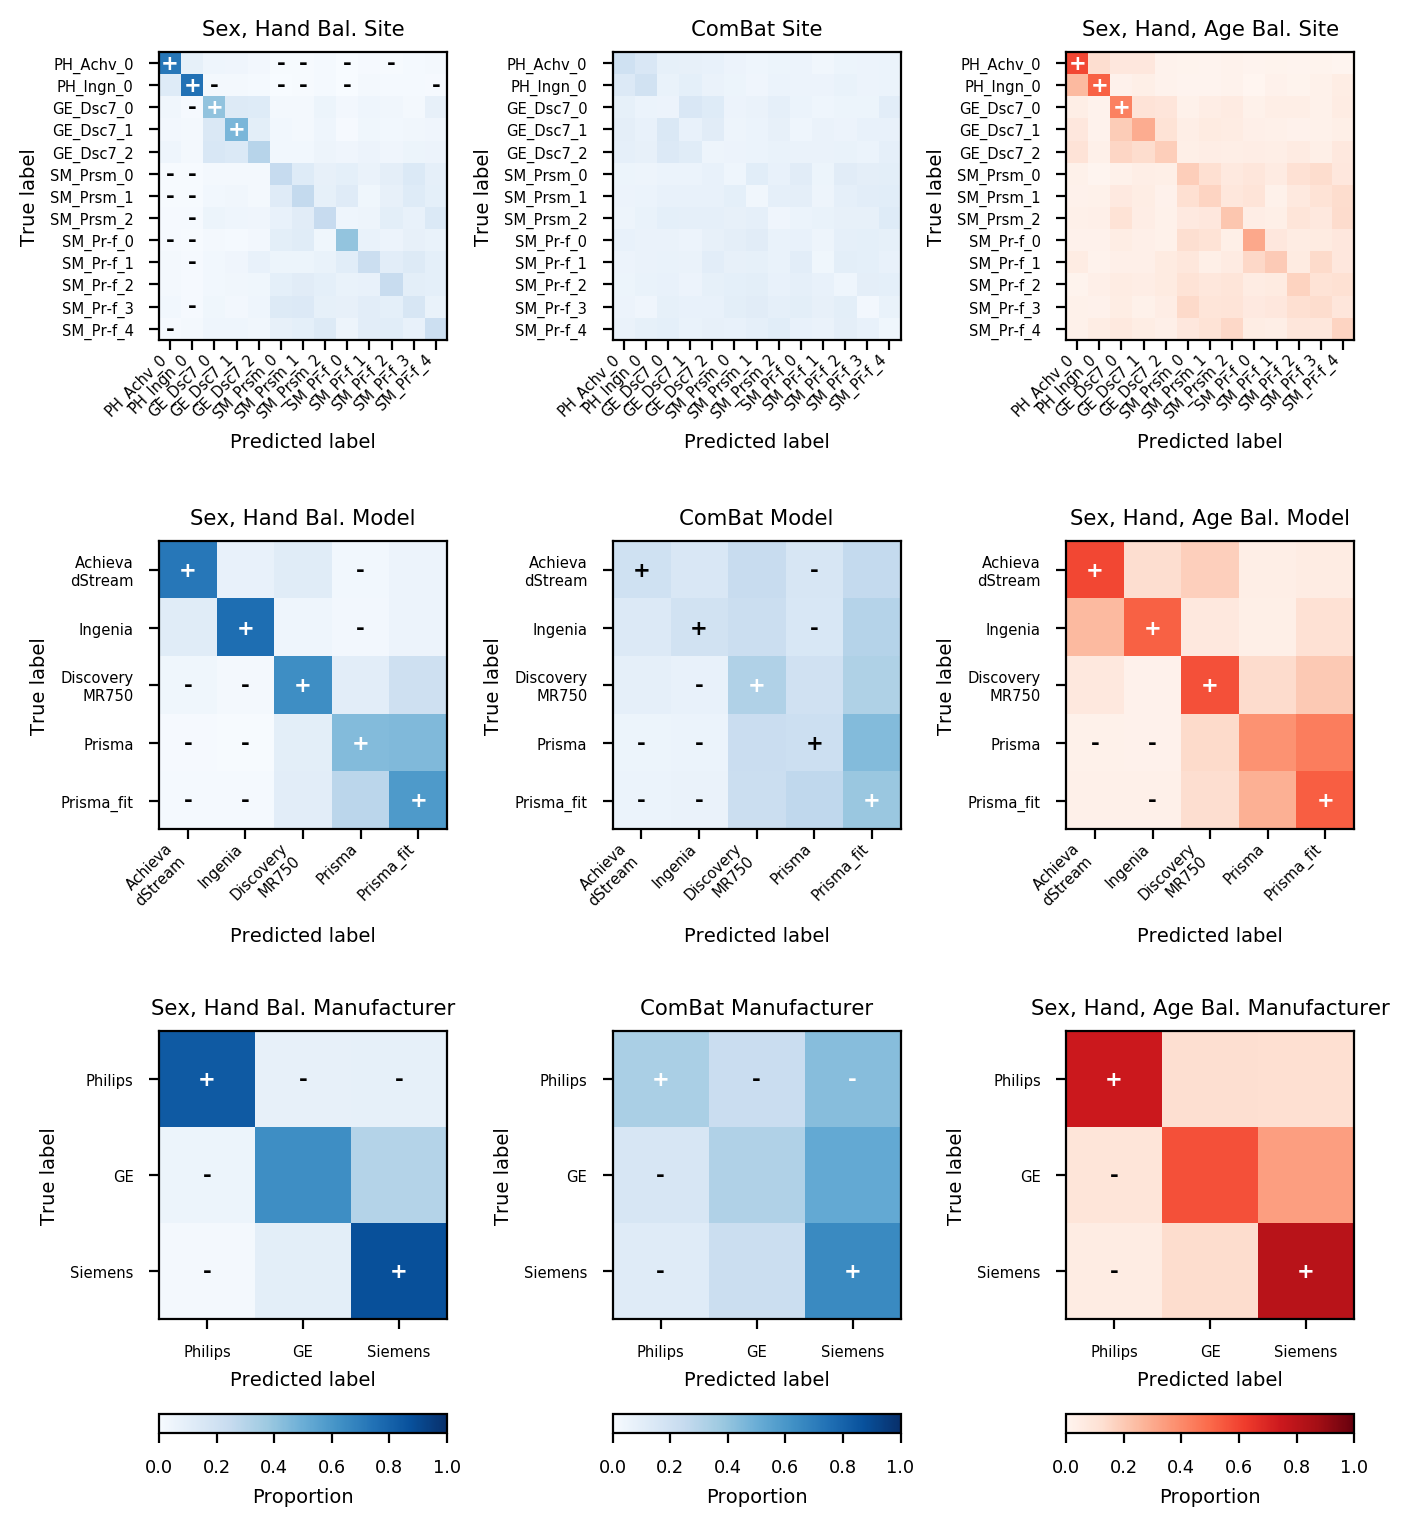

In [879]:
sns.set_context('paper', font_scale = 0.8)
#fig,axes = plt.subplots(3,1, figsize = (, 11), dpi = 100)
fig = plt.figure(figsize = (7, 8), dpi = 200)
gs = gridspec.GridSpec(4,3, height_ratios=[8,8,8,0.5])
axes = [plt.subplot(g) for g in gs]

# Raw
_fig,_ax,im0 = plot_confusion_matrix(cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="Sex, Hand Bal. Site",
                      signed_ps = cfn_signed_ps[reo_ind,:][:,reo_ind], colorbar=False, ax=axes[0], fig=fig, sig_thresh=0.0025, symbols=True)

labels = axes[0].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
model_cfn = model_cfns.mean(0)
model_reo = [1,2,0,3,4]
plot_confusion_matrix(model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="Sex, Hand Bal. Model",
                      signed_ps = model_cfn_signed_ps_norm[model_reo, :][:, model_reo], colorbar=False, ax=axes[3], sig_thresh=0.0025, symbols=True)
labels = axes[3].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_reo = [1,0,2]
plot_confusion_matrix(mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="Sex, Hand Bal. Manufacturer",
                      signed_ps = mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo],  colorbar=False, ax=axes[6], sig_thresh=0.0025, symbols=True)
#axes[0].figure.tight_layout()

# Combat
_fig,_ax,im1 = plot_confusion_matrix(cb_cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="ComBat Site",
                      signed_ps = cb_cfn_signed_ps[reo_ind,:][:,reo_ind], colorbar=False, ax=axes[1], fig=fig, sig_thresh=0.0025, symbols=True)

labels = axes[1].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
cb_model_cfn = cb_model_cfns.mean(0)
model_reo = [1,2,0,3,4]
plot_confusion_matrix(cb_model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="ComBat Model",
                      signed_ps = cb_model_cfn_signed_ps_norm[model_reo, :][:, model_reo], colorbar=False, ax=axes[4], sig_thresh=0.0025, symbols=True)
labels = axes[4].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_reo = [1,0,2]
cb_mfg_cfn = cb_mfg_cfns.mean(0)
plot_confusion_matrix(cb_mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="ComBat Manufacturer",
                      signed_ps = cb_mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo], colorbar=False, ax=axes[7], sig_thresh=0.0025, symbols=True)
#axes[0].figure.tight_layout()
#fig.tight_layout()



#Age balanced
_fig,_ax,im2 = plot_confusion_matrix(ab_cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="Sex, Hand, Age Bal. Site",
                      signed_ps = ab_cfn_signed_ps[reo_ind,:][:,reo_ind], cmap=plt.cm.Reds, colorbar=False, ax=axes[2], fig=fig, sig_thresh=0.0025, symbols=True)

labels = axes[2].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
ab_model_cfn = ab_model_cfns.mean(0)
model_reo = [1,2,0,3,4]
plot_confusion_matrix(ab_model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="Sex, Hand, Age Bal. Model",
                      signed_ps = ab_model_cfn_signed_ps_norm[model_reo, :][:, model_reo], cmap=plt.cm.Reds, colorbar=False, ax=axes[5], sig_thresh=0.0025, symbols=True)
labels = axes[5].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_reo = [1,0,2]
ab_mfg_cfn = ab_mfg_cfns.mean(0)
plot_confusion_matrix(ab_mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="Sex, Hand, Age Bal. Manufacturer",
                      signed_ps = ab_mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo], cmap=plt.cm.Reds, colorbar=False, ax=axes[8], sig_thresh=0.0025, symbols=True)
#axes[0].figure.tight_layout()
fig.tight_layout()

fig.colorbar(im0, cax = axes[9], orientation='horizontal')
axes[9].set_xlabel('Proportion')
axes[9].set_aspect(0.065)
cbbox = axes[9].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[9].set_position(cbbox)

fig.colorbar(im1, cax = axes[10], orientation='horizontal')
axes[10].set_xlabel('Proportion')
axes[10].set_aspect(0.065)
cbbox = axes[10].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[10].set_position(cbbox)

fig.colorbar(im2, cax = axes[11], orientation='horizontal')
axes[11].set_xlabel('Proportion')
axes[11].set_aspect(0.065)
cbbox = axes[11].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[11].set_position(cbbox)
#fig.tight_layout()



Confusion Matrices for Classification of Site with Resting State Data with Aggregation to Model and Manufacturer Levels. 
Intensity of the color in each cell represents the proportion of examples that were truly of that class the model predicted to be in that class. The diagonal represents correct classificiations and the off-diagonal represents incorrect classifications. We ran 1079 permutations balanced across gender, handedness and age in 3 month bins to determine chance classifier performance. Plusses and minusses indicate cells with significantly higher or lower values than excpected by chance at a two sided threshold of p < 0.005. Sites are identified by abrevieaitons reflecting the manufactuerer, model, and an aribrary index number. The top row shows confusion matricies for classification of site from resting state data in test sets averaged across three-fold cross validation from 25 draws for the Sex, Handedness Balanced and ComBat corrected data and split-half cross validation from 25 draws for the  Sex, Handedness, Age Balanced data. The second and third rows show these same results aggregated accross sites to the model and manufacturer levels. The Sex, Handedness Balanced Site matrix demonstrates that site was classifiable in the resting state data, particularly for the Philips and GE sites and that Philips data was rarely classified as coming from a Siemens site. In the ComBat Site matrix we see that training ComBat on the training splits and applying it to the test splits reduces classifiabiilty of site to below chance levels. Site classification still performed above chance for the two Philips sites and one of the GE sites in the Sex, Handedness, Age Balanced data, demonstrating that classifibility of the resting state data was not driven by trivial differences in age distributions between sites. Aggregating to the model level we see that site classification errors were more likely to occur between sites using the same model of MRI scanner, and that ComBat correction for site did not eliminated this tendency. Aggregating to the Manufactuer level demonstrates that site calssification errors were also likely to occur between sites using the same Manufactuerer and that ComBat does not eliminate this tendency. Finally, we hope it is clear that we only trained the classifier to identify site, not model or manufactuerer; the results shown here are aggregations of site performance based on model or manufactuerer to demonstrate the patterns of errors in site classification.

In [881]:
classes

array(['PH_Achv_0', 'PH_Ingn_0', 'GE_Dsc7_0', 'GE_Dsc7_1', 'GE_Dsc7_2',
       'SM_Prsm_0', 'SM_Prsm_1', 'SM_Prsm_2', 'SM_Pr-f_0', 'SM_Pr-f_1',
       'SM_Pr-f_2', 'SM_Pr-f_3', 'SM_Pr-f_4'], dtype=object)

In [699]:
sns.set_context('talk', font_scale = 0.8)
#fig,axes = plt.subplots(3,1, figsize = (, 11), dpi = 100)
fig = plt.figure(figsize = (18, 12), dpi = 200)
gs = gridspec.GridSpec(4,3, height_ratios=[8,8,8,0.5])
axes = [plt.subplot(g) for g in gs]
_fig,_ax,im = plot_confusion_matrix(cfns.mean(0)[reo_ind,:][:,reo_ind], classes, normalize=True, numbers=False, title="Site",
                      signed_ps = cfn_signed_ps[reo_ind,:][:,reo_ind], colorbar=False, ax=axes[0], fig=fig, sig_thresh=0.0025, symbols=True)

labels = axes[0].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
    
model_cfn = model_cfns.mean(0)
model_reo = [1,2,0,3,4]
plot_confusion_matrix(model_cfn[model_reo, :][:, model_reo], np.array(mdl_labels)[model_reo], normalize=True, numbers=False, title="Model",
                      signed_ps = model_cfn_signed_ps_norm[model_reo, :][:, model_reo], colorbar=False, ax=axes[1], sig_thresh=0.0025, symbols=True)
labels = axes[1].get_xticklabels()
for i,label in enumerate(labels):
    label.set_ha('right')
    label.set_rotation(45)
    x, y = label.get_position()
    y = y+0.05
    label.set_position((x,y))
mfg_reo = [1,0,2]
plot_confusion_matrix(mfg_cfn[mfg_reo, :][:, mfg_reo], np.array(mfg_labels)[mfg_reo], normalize=True, numbers=False, title="Manufacturer",
                      signed_ps = mfg_cfn_signed_ps_norm[mfg_reo, :][:, mfg_reo],  colorbar=False, ax=axes[2], sig_thresh=0.0025, symbols=True)
#axes[0].figure.tight_layout()
fig.tight_layout()
fig.colorbar(im, cax = axes[3], orientation='horizontal')
axes[3].set_xlabel('Proportion')
axes[3].set_aspect(0.065)
cbbox = axes[3].get_position()
cbbox.y0 = cbbox.y0 + 0.05
cbbox.y1 = cbbox.y1 + 0.05
axes[3].set_position(cbbox)
#fig.tight_layout()

In [ ]:


ab_model_cfns, ab_mfg_cfns, ab_model_cfn_signed_ps_norm, ab_mfg_cfn_signed_ps_norm = get_collapsed_perms(ab_cfns, ab_perm_cfns)
cb_model_cfns, cb_mfg_cfns, cb_model_cfn_signed_ps_norm, cb_mfg_cfn_signed_ps_norm = get_collapsed_perms(cb_cfns, cb_perm_cfns)

In [ ]:
model_cfns = np.array([collapse_group(cfn, model_lut, model_order, normalize=False) for cfn in cfns])
model_perm_cfns = np.array([[collapse_group(pcfn, model_lut, model_order, normalize=False) for pcfn in pc] for pc in perm_cfns])
mfg_cfns = np.array([collapse_group(cfn, mfg_lut, mfg_order, normalize=False) for cfn in cfns])
mfg_perm_cfns = np.array([[collapse_group(pcfn, mfg_lut, mfg_order, normalize=False) for pcfn in pc] for pc in perm_cfns])

In [168]:
model_cfns_norm = np.array([collapse_group(cfn, model_lut, model_order, normalize=True) for cfn in cfns])
model_perm_cfns_norm = np.array([[collapse_group(pcfn, model_lut, model_order, normalize=True) for pcfn in pc] for pc in perm_cfns])
mfg_cfns_norm = np.array([collapse_group(cfn, mfg_lut, mfg_order, normalize=True) for cfn in cfns])
mfg_perm_cfns_norm = np.array([[collapse_group(pcfn, mfg_lut, mfg_order, normalize=True) for pcfn in pc] for pc in perm_cfns])


In [170]:
model_cfn_signed_ps_norm = get_cfn_sig(model_cfns_norm, model_perm_cfns_norm)
mfg_cfn_signed_ps_norm = get_cfn_sig(mfg_cfns_norm, mfg_perm_cfns_norm)

Confusion matrix, without normalization
[[ 56.90666667   3.13333333   1.58666667   9.13333333  18.24      ]
 [  3.38666667  21.54666667   2.2          0.88         1.65333333]
 [  1.28         3.42666667  22.53333333   0.72         1.70666667]
 [  8.78666667   0.8          0.58666667  38.94666667  39.88      ]
 [ 15.28         2.10666667   1.82666667  41.88        87.24      ]]


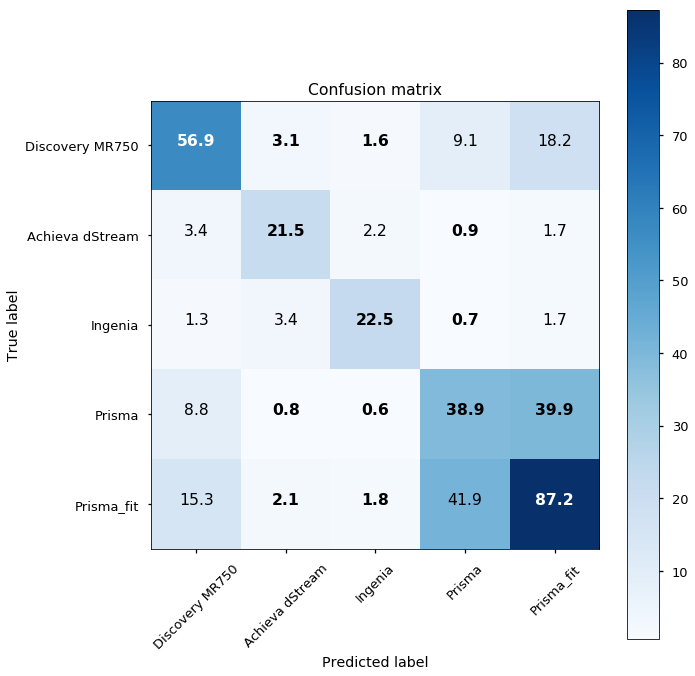

In [172]:
sns.set_context('talk')
model_cfn = model_cfns.mean(0)
fig,ax = plt.subplots(1, figsize = (10,10))
plot_confusion_matrix(model_cfn, mdl_labels, normalize=False,
                      signed_ps = model_cfn_signed_ps_norm)

In [178]:
mfg_cfns_norm.mean(0)

array([[ 0.63939205,  0.05279467,  0.30781328],
       [ 0.07864209,  0.83821813,  0.08313978],
       [ 0.10137148,  0.02230402,  0.8763245 ]])

Confusion matrix, without normalization
[[  56.90666667    4.72         27.37333333]
 [   4.66666667   49.70666667    4.96      ]
 [  24.06666667    5.32        207.94666667]]


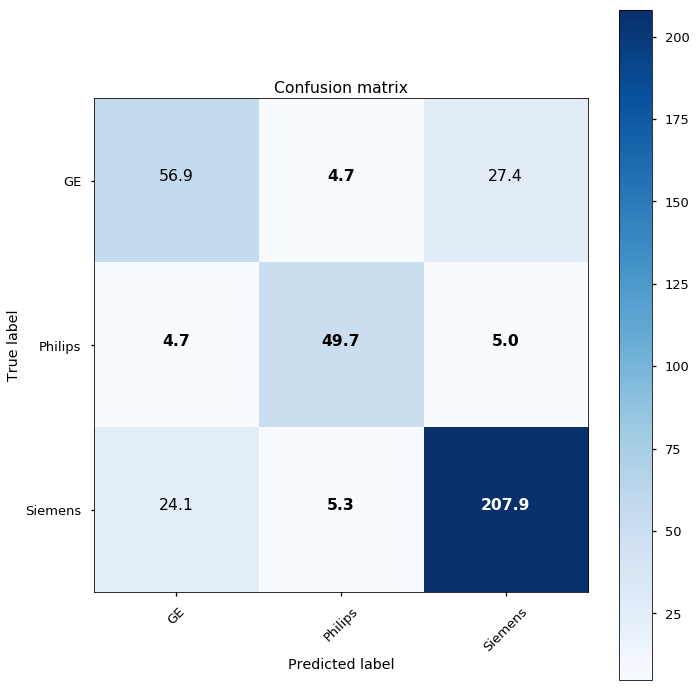

In [173]:
sns.set_context('talk')
mfg_cfn = mfg_cfns.mean(0)
fig,ax = plt.subplots(1, figsize = (10,10))
plot_confusion_matrix(mfg_cfn, mfg_labels, normalize=False,
                      signed_ps = mfg_cfn_signed_ps_norm)

In [ ]:
d